In [62]:
import torch
import torch.nn as nn
import yaml
import torch.distributions as distributions
import torch.optim as optim
from critic import Criticnet, SmallMLP
from scorenet import Scorenet
import os
from datasets import toy_data
import numpy as np 
import matplotlib
from utils import keep_grad, approx_jacobian_trace, exact_jacobian_trace, \
    set_random_seed, get_logger, dict2namespace, get_opt, visualize_2d, langevin_dynamics_lsd
import importlib
import argparse
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config_file = './test_config_toy_2d.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/nfs/rhea.dgp/u6/a/mrsalehi/.virtualenvs/base/lib/python3.6/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


Namespace(data=Namespace(batch_size=1, cates=None, data_dir=None, dataset_scale=1, dataset_type='pinwheel', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='pinwheel'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/test-toy-2d', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1

In [64]:
def sample_data(data, n_points):
    x = toy_data.inf_train_gen(data, n_points=n_points)
#     plt.scatter(x[:, 0], x[:, 1])
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

In [65]:
_ = sample_data('one_moon', 1000)

In [66]:
score_net = SmallMLP(n_dims=2, n_out=2)
critic_net = SmallMLP(n_dims=2, n_out=2)

critic_net.to(device)
score_net.to(device)

opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

k_iters = 5
e_iters = 1
epochs = 15000
itr = 0

losses = []

for epoch in range(epochs):
    tr_pts = sample_data('one_moon', 2048).view(-1, 2)
    
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()

    tr_pts.requires_grad_()
    batch_size = tr_pts.size(0)

    perturbed_points = tr_pts

    score_pred = score_net(perturbed_points)

    critic_output = critic_net(perturbed_points)

    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)

    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()

    losses.append(loss)

    cycle_iter = itr % (k_iters + e_iters)

    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()

    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        log_message = "Epoch %d (critic), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)
    else:
        loss.backward()
        opt_scorenet.step()
        log_message = "Epoch %d (score), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)

    print(log_message)
    itr += 1

#     if itr % cfg.log.save_freq == 0:
#         score_net.cpu()

#         torch.save({
#             'args': args,
#             'state_dict': score_net.state_dict(),
#         }, os.path.join(cfg.log.save_dir, 'checkpt.pth'))

#         score_net.to(device)

#     if itr % cfg.log.viz_freq == 0:
#         plt.clf()

#         #pt_cl, _ = langevin_dynamics(score_net, sigmas, dim=2, eps=1e-4, num_steps=cfg.inference.num_steps)
#         x_final = langevin_dynamics_lsd(score_net, l=1., e=.01, num_points=2048, n_steps=10)

#         visualize_2d(x_final)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'sample-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)


#         visualize_2d(perturbed_points)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'perturbed-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)

#     itr += 1

Epoch 0 (critic), Loss=-0.05431 t1=-0.00399 t2=-0.05031
Epoch 1 (critic), Loss=0.31245 t1=0.00731 t2=0.30514
Epoch 2 (critic), Loss=0.67288 t1=0.01670 t2=0.65617
Epoch 3 (critic), Loss=1.02744 t1=0.02441 t2=1.00302
Epoch 4 (critic), Loss=1.37591 t1=0.02975 t2=1.34616
Epoch 5 (score), Loss=1.72094 t1=0.03414 t2=1.68679
Epoch 6 (critic), Loss=1.57415 t1=-0.11299 t2=1.68714
Epoch 7 (critic), Loss=1.88562 t1=-0.12374 t2=2.00936
Epoch 8 (critic), Loss=2.18427 t1=-0.12687 t2=2.31115
Epoch 9 (critic), Loss=2.46531 t1=-0.12900 t2=2.59431
Epoch 10 (critic), Loss=2.73185 t1=-0.12590 t2=2.85775
Epoch 11 (score), Loss=2.98535 t1=-0.12018 t2=3.10553
Epoch 12 (critic), Loss=2.81849 t1=-0.28775 t2=3.10625
Epoch 13 (critic), Loss=3.06271 t1=-0.26883 t2=3.33154
Epoch 14 (critic), Loss=3.29713 t1=-0.24903 t2=3.54617
Epoch 15 (critic), Loss=3.53210 t1=-0.22937 t2=3.76148
Epoch 16 (critic), Loss=3.77272 t1=-0.21345 t2=3.98617
Epoch 17 (score), Loss=4.02279 t1=-0.20501 t2=4.22780
Epoch 18 (critic), Loss=3.

Epoch 174 (critic), Loss=39.95282 t1=-1.61207 t2=41.56489
Epoch 175 (critic), Loss=39.73081 t1=-1.00251 t2=40.73332
Epoch 176 (critic), Loss=39.35789 t1=-1.42713 t2=40.78502
Epoch 177 (critic), Loss=39.79025 t1=-1.31706 t2=41.10732
Epoch 178 (critic), Loss=40.19273 t1=-1.85528 t2=42.04801
Epoch 179 (score), Loss=40.09603 t1=-1.85519 t2=41.95121
Epoch 180 (critic), Loss=40.27782 t1=-1.40748 t2=41.68531
Epoch 181 (critic), Loss=40.20111 t1=-0.92612 t2=41.12724
Epoch 182 (critic), Loss=40.61649 t1=-1.50668 t2=42.12317
Epoch 183 (critic), Loss=40.33043 t1=-1.24590 t2=41.57633
Epoch 184 (critic), Loss=40.33697 t1=-0.96039 t2=41.29737
Epoch 185 (score), Loss=40.18155 t1=-0.55601 t2=40.73756
Epoch 186 (critic), Loss=40.38776 t1=-0.39465 t2=40.78240
Epoch 187 (critic), Loss=40.26759 t1=-0.98989 t2=41.25748
Epoch 188 (critic), Loss=40.52884 t1=-1.16854 t2=41.69738
Epoch 189 (critic), Loss=40.30356 t1=-1.48757 t2=41.79113
Epoch 190 (critic), Loss=40.85205 t1=-1.10617 t2=41.95821
Epoch 191 (score

Epoch 324 (critic), Loss=38.85135 t1=-2.12997 t2=40.98132
Epoch 325 (critic), Loss=38.68057 t1=-1.91213 t2=40.59270
Epoch 326 (critic), Loss=39.07949 t1=-0.99529 t2=40.07478
Epoch 327 (critic), Loss=39.31493 t1=-0.62580 t2=39.94073
Epoch 328 (critic), Loss=38.56334 t1=-1.86239 t2=40.42574
Epoch 329 (score), Loss=38.81166 t1=-1.20560 t2=40.01726
Epoch 330 (critic), Loss=38.80099 t1=-1.54562 t2=40.34660
Epoch 331 (critic), Loss=38.24060 t1=-2.32378 t2=40.56439
Epoch 332 (critic), Loss=38.31119 t1=-2.57644 t2=40.88762
Epoch 333 (critic), Loss=38.57096 t1=-2.35113 t2=40.92210
Epoch 334 (critic), Loss=38.92163 t1=-1.11576 t2=40.03740
Epoch 335 (score), Loss=38.51237 t1=-1.79993 t2=40.31231
Epoch 336 (critic), Loss=38.12223 t1=-2.62506 t2=40.74728
Epoch 337 (critic), Loss=38.11006 t1=-2.30514 t2=40.41521
Epoch 338 (critic), Loss=38.20265 t1=-2.56708 t2=40.76972
Epoch 339 (critic), Loss=38.08388 t1=-2.17395 t2=40.25783
Epoch 340 (critic), Loss=38.09634 t1=-2.35059 t2=40.44693
Epoch 341 (score

Epoch 474 (critic), Loss=29.14534 t1=-6.09682 t2=35.24216
Epoch 475 (critic), Loss=29.70264 t1=-5.70042 t2=35.40306
Epoch 476 (critic), Loss=29.14429 t1=-7.65065 t2=36.79494
Epoch 477 (critic), Loss=29.28204 t1=-7.13673 t2=36.41877
Epoch 478 (critic), Loss=28.98142 t1=-7.07934 t2=36.06076
Epoch 479 (score), Loss=28.55049 t1=-6.76578 t2=35.31627
Epoch 480 (critic), Loss=29.16355 t1=-6.65415 t2=35.81770
Epoch 481 (critic), Loss=29.13759 t1=-5.24889 t2=34.38648
Epoch 482 (critic), Loss=28.81408 t1=-5.87308 t2=34.68716
Epoch 483 (critic), Loss=28.82310 t1=-5.74409 t2=34.56720
Epoch 484 (critic), Loss=28.25778 t1=-7.61793 t2=35.87571
Epoch 485 (score), Loss=28.64144 t1=-7.08998 t2=35.73141
Epoch 486 (critic), Loss=28.56073 t1=-7.43160 t2=35.99233
Epoch 487 (critic), Loss=28.97631 t1=-6.89522 t2=35.87154
Epoch 488 (critic), Loss=29.23715 t1=-6.09868 t2=35.33584
Epoch 489 (critic), Loss=29.16735 t1=-5.24812 t2=34.41547
Epoch 490 (critic), Loss=28.28407 t1=-5.41228 t2=33.69635
Epoch 491 (score

Epoch 624 (critic), Loss=21.99895 t1=-4.10802 t2=26.10697
Epoch 625 (critic), Loss=21.88394 t1=-4.23676 t2=26.12070
Epoch 626 (critic), Loss=22.08370 t1=-4.64760 t2=26.73130
Epoch 627 (critic), Loss=21.95117 t1=-4.90058 t2=26.85176
Epoch 628 (critic), Loss=22.56681 t1=-3.98689 t2=26.55370
Epoch 629 (score), Loss=22.63926 t1=-4.31273 t2=26.95199
Epoch 630 (critic), Loss=22.77802 t1=-4.52804 t2=27.30606
Epoch 631 (critic), Loss=22.79556 t1=-3.96652 t2=26.76208
Epoch 632 (critic), Loss=21.66038 t1=-4.85306 t2=26.51344
Epoch 633 (critic), Loss=22.16571 t1=-2.76971 t2=24.93542
Epoch 634 (critic), Loss=22.29728 t1=-2.46052 t2=24.75780
Epoch 635 (score), Loss=21.99556 t1=-3.08604 t2=25.08160
Epoch 636 (critic), Loss=21.50838 t1=-3.60617 t2=25.11455
Epoch 637 (critic), Loss=22.00458 t1=-3.27669 t2=25.28127
Epoch 638 (critic), Loss=21.72455 t1=-3.84745 t2=25.57199
Epoch 639 (critic), Loss=21.67321 t1=-4.49374 t2=26.16694
Epoch 640 (critic), Loss=21.81298 t1=-4.13117 t2=25.94415
Epoch 641 (score

Epoch 774 (critic), Loss=19.26607 t1=-3.87444 t2=23.14051
Epoch 775 (critic), Loss=18.75053 t1=-3.99414 t2=22.74467
Epoch 776 (critic), Loss=19.32958 t1=-3.18062 t2=22.51020
Epoch 777 (critic), Loss=18.88116 t1=-3.68532 t2=22.56648
Epoch 778 (critic), Loss=18.80024 t1=-2.91280 t2=21.71304
Epoch 779 (score), Loss=18.64543 t1=-2.96915 t2=21.61458
Epoch 780 (critic), Loss=19.25236 t1=-2.85905 t2=22.11141
Epoch 781 (critic), Loss=19.34129 t1=-2.37312 t2=21.71441
Epoch 782 (critic), Loss=18.43068 t1=-2.96902 t2=21.39970
Epoch 783 (critic), Loss=19.21788 t1=-2.76582 t2=21.98370
Epoch 784 (critic), Loss=18.94500 t1=-3.33408 t2=22.27908
Epoch 785 (score), Loss=19.01066 t1=-3.52585 t2=22.53651
Epoch 786 (critic), Loss=19.16951 t1=-3.05749 t2=22.22701
Epoch 787 (critic), Loss=19.00027 t1=-3.56592 t2=22.56620
Epoch 788 (critic), Loss=18.46170 t1=-3.79611 t2=22.25781
Epoch 789 (critic), Loss=18.91418 t1=-3.47021 t2=22.38438
Epoch 790 (critic), Loss=18.89656 t1=-3.40103 t2=22.29759
Epoch 791 (score

Epoch 924 (critic), Loss=13.98714 t1=-5.88284 t2=19.86999
Epoch 925 (critic), Loss=13.93143 t1=-5.51196 t2=19.44340
Epoch 926 (critic), Loss=14.28619 t1=-5.53230 t2=19.81849
Epoch 927 (critic), Loss=14.67300 t1=-5.62207 t2=20.29507
Epoch 928 (critic), Loss=14.35855 t1=-5.37268 t2=19.73123
Epoch 929 (score), Loss=14.48643 t1=-5.19482 t2=19.68125
Epoch 930 (critic), Loss=13.41947 t1=-5.97529 t2=19.39476
Epoch 931 (critic), Loss=13.65252 t1=-5.52402 t2=19.17654
Epoch 932 (critic), Loss=14.32228 t1=-5.85674 t2=20.17902
Epoch 933 (critic), Loss=13.44772 t1=-5.55883 t2=19.00655
Epoch 934 (critic), Loss=13.60020 t1=-5.35977 t2=18.95997
Epoch 935 (score), Loss=13.60709 t1=-5.26891 t2=18.87601
Epoch 936 (critic), Loss=13.41835 t1=-5.76365 t2=19.18200
Epoch 937 (critic), Loss=13.38802 t1=-5.70917 t2=19.09719
Epoch 938 (critic), Loss=13.13210 t1=-6.23219 t2=19.36429
Epoch 939 (critic), Loss=13.55200 t1=-5.61706 t2=19.16906
Epoch 940 (critic), Loss=13.97329 t1=-5.27231 t2=19.24559
Epoch 941 (score

Epoch 1074 (critic), Loss=9.84460 t1=-5.62246 t2=15.46706
Epoch 1075 (critic), Loss=9.80154 t1=-5.82175 t2=15.62330
Epoch 1076 (critic), Loss=9.14894 t1=-6.47859 t2=15.62753
Epoch 1077 (critic), Loss=10.09535 t1=-4.92845 t2=15.02380
Epoch 1078 (critic), Loss=9.39498 t1=-5.36012 t2=14.75510
Epoch 1079 (score), Loss=10.02265 t1=-3.97882 t2=14.00147
Epoch 1080 (critic), Loss=10.03613 t1=-4.62661 t2=14.66274
Epoch 1081 (critic), Loss=9.56969 t1=-4.29791 t2=13.86760
Epoch 1082 (critic), Loss=9.70771 t1=-4.53660 t2=14.24430
Epoch 1083 (critic), Loss=9.63262 t1=-4.94708 t2=14.57969
Epoch 1084 (critic), Loss=8.85325 t1=-5.72757 t2=14.58082
Epoch 1085 (score), Loss=9.88487 t1=-4.28636 t2=14.17123
Epoch 1086 (critic), Loss=8.97988 t1=-5.28472 t2=14.26460
Epoch 1087 (critic), Loss=9.58094 t1=-5.19015 t2=14.77109
Epoch 1088 (critic), Loss=8.65588 t1=-6.06726 t2=14.72314
Epoch 1089 (critic), Loss=8.84565 t1=-5.55124 t2=14.39688
Epoch 1090 (critic), Loss=9.33228 t1=-5.01514 t2=14.34742
Epoch 1091 (s

Epoch 1222 (critic), Loss=6.73349 t1=-5.49852 t2=12.23201
Epoch 1223 (score), Loss=6.86191 t1=-5.38416 t2=12.24607
Epoch 1224 (critic), Loss=6.91834 t1=-5.15625 t2=12.07459
Epoch 1225 (critic), Loss=6.24222 t1=-6.01426 t2=12.25648
Epoch 1226 (critic), Loss=6.59887 t1=-5.00444 t2=11.60331
Epoch 1227 (critic), Loss=6.57731 t1=-4.93017 t2=11.50748
Epoch 1228 (critic), Loss=6.97551 t1=-4.46332 t2=11.43883
Epoch 1229 (score), Loss=6.59349 t1=-4.79165 t2=11.38513
Epoch 1230 (critic), Loss=6.39804 t1=-5.19145 t2=11.58949
Epoch 1231 (critic), Loss=6.67928 t1=-4.93954 t2=11.61882
Epoch 1232 (critic), Loss=6.88320 t1=-4.47793 t2=11.36113
Epoch 1233 (critic), Loss=6.77092 t1=-4.85069 t2=11.62162
Epoch 1234 (critic), Loss=6.22507 t1=-5.44474 t2=11.66980
Epoch 1235 (score), Loss=6.16474 t1=-5.20534 t2=11.37008
Epoch 1236 (critic), Loss=6.87687 t1=-5.21314 t2=12.09001
Epoch 1237 (critic), Loss=6.54439 t1=-5.06263 t2=11.60703
Epoch 1238 (critic), Loss=6.94690 t1=-4.73515 t2=11.68204
Epoch 1239 (criti

Epoch 1372 (critic), Loss=5.05587 t1=-4.60827 t2=9.66414
Epoch 1373 (score), Loss=4.88402 t1=-4.87946 t2=9.76348
Epoch 1374 (critic), Loss=5.42121 t1=-4.46433 t2=9.88553
Epoch 1375 (critic), Loss=4.37654 t1=-5.15046 t2=9.52699
Epoch 1376 (critic), Loss=4.91805 t1=-4.27706 t2=9.19511
Epoch 1377 (critic), Loss=5.03353 t1=-3.44286 t2=8.47640
Epoch 1378 (critic), Loss=4.38884 t1=-3.74133 t2=8.13017
Epoch 1379 (score), Loss=4.96451 t1=-3.04179 t2=8.00630
Epoch 1380 (critic), Loss=5.17856 t1=-2.93657 t2=8.11513
Epoch 1381 (critic), Loss=5.01728 t1=-3.31986 t2=8.33714
Epoch 1382 (critic), Loss=5.23570 t1=-3.53124 t2=8.76694
Epoch 1383 (critic), Loss=5.19067 t1=-4.03256 t2=9.22323
Epoch 1384 (critic), Loss=4.10253 t1=-5.21433 t2=9.31686
Epoch 1385 (score), Loss=4.34987 t1=-5.43321 t2=9.78308
Epoch 1386 (critic), Loss=4.50481 t1=-5.39807 t2=9.90288
Epoch 1387 (critic), Loss=4.71842 t1=-4.72204 t2=9.44045
Epoch 1388 (critic), Loss=3.99545 t1=-5.38865 t2=9.38410
Epoch 1389 (critic), Loss=4.70406 

Epoch 1522 (critic), Loss=3.48920 t1=-3.70381 t2=7.19301
Epoch 1523 (score), Loss=3.40893 t1=-3.54077 t2=6.94970
Epoch 1524 (critic), Loss=3.58715 t1=-3.57728 t2=7.16443
Epoch 1525 (critic), Loss=4.06992 t1=-2.78015 t2=6.85008
Epoch 1526 (critic), Loss=3.81597 t1=-2.77713 t2=6.59311
Epoch 1527 (critic), Loss=3.92064 t1=-2.38166 t2=6.30230
Epoch 1528 (critic), Loss=3.75849 t1=-2.75296 t2=6.51145
Epoch 1529 (score), Loss=3.55249 t1=-2.54178 t2=6.09427
Epoch 1530 (critic), Loss=3.70521 t1=-2.58992 t2=6.29513
Epoch 1531 (critic), Loss=3.92087 t1=-2.44863 t2=6.36951
Epoch 1532 (critic), Loss=3.59776 t1=-2.82829 t2=6.42604
Epoch 1533 (critic), Loss=3.54508 t1=-3.35396 t2=6.89904
Epoch 1534 (critic), Loss=3.85011 t1=-3.14139 t2=6.99150
Epoch 1535 (score), Loss=3.99081 t1=-3.58045 t2=7.57126
Epoch 1536 (critic), Loss=3.75179 t1=-3.51428 t2=7.26608
Epoch 1537 (critic), Loss=2.94999 t1=-4.19254 t2=7.14253
Epoch 1538 (critic), Loss=3.60216 t1=-3.60833 t2=7.21049
Epoch 1539 (critic), Loss=3.68793 

Epoch 1672 (critic), Loss=3.68193 t1=-2.43915 t2=6.12108
Epoch 1673 (score), Loss=3.30488 t1=-2.65757 t2=5.96246
Epoch 1674 (critic), Loss=3.25142 t1=-2.86091 t2=6.11233
Epoch 1675 (critic), Loss=2.64252 t1=-3.10803 t2=5.75055
Epoch 1676 (critic), Loss=3.29286 t1=-2.09582 t2=5.38867
Epoch 1677 (critic), Loss=2.97120 t1=-1.58997 t2=4.56117
Epoch 1678 (critic), Loss=2.83732 t1=-1.42932 t2=4.26664
Epoch 1679 (score), Loss=3.10939 t1=-0.96191 t2=4.07131
Epoch 1680 (critic), Loss=2.81440 t1=-1.32358 t2=4.13799
Epoch 1681 (critic), Loss=3.04974 t1=-1.32796 t2=4.37769
Epoch 1682 (critic), Loss=3.03962 t1=-1.45796 t2=4.49758
Epoch 1683 (critic), Loss=2.93632 t1=-2.18244 t2=5.11876
Epoch 1684 (critic), Loss=3.08157 t1=-2.41029 t2=5.49187
Epoch 1685 (score), Loss=3.38685 t1=-2.44888 t2=5.83574
Epoch 1686 (critic), Loss=2.68716 t1=-2.84025 t2=5.52741
Epoch 1687 (critic), Loss=2.86642 t1=-2.75241 t2=5.61883
Epoch 1688 (critic), Loss=2.68740 t1=-2.39553 t2=5.08293
Epoch 1689 (critic), Loss=2.66769 

Epoch 1822 (critic), Loss=2.40393 t1=-2.05207 t2=4.45600
Epoch 1823 (score), Loss=2.19930 t1=-1.92738 t2=4.12667
Epoch 1824 (critic), Loss=2.16832 t1=-2.47270 t2=4.64102
Epoch 1825 (critic), Loss=2.58815 t1=-1.16909 t2=3.75724
Epoch 1826 (critic), Loss=2.85393 t1=-0.61406 t2=3.46800
Epoch 1827 (critic), Loss=2.43014 t1=-0.74137 t2=3.17151
Epoch 1828 (critic), Loss=2.89895 t1=-0.58126 t2=3.48021
Epoch 1829 (score), Loss=2.33049 t1=-0.85575 t2=3.18624
Epoch 1830 (critic), Loss=2.43790 t1=-0.68928 t2=3.12718
Epoch 1831 (critic), Loss=2.19129 t1=-1.02036 t2=3.21165
Epoch 1832 (critic), Loss=2.43657 t1=-1.57407 t2=4.01064
Epoch 1833 (critic), Loss=2.64702 t1=-1.82610 t2=4.47312
Epoch 1834 (critic), Loss=2.28671 t1=-2.38702 t2=4.67373
Epoch 1835 (score), Loss=2.68902 t1=-2.18012 t2=4.86914
Epoch 1836 (critic), Loss=2.35849 t1=-2.51000 t2=4.86849
Epoch 1837 (critic), Loss=2.68019 t1=-2.40402 t2=5.08421
Epoch 1838 (critic), Loss=2.69324 t1=-1.95129 t2=4.64453
Epoch 1839 (critic), Loss=2.51256 

Epoch 1972 (critic), Loss=2.09556 t1=-0.66090 t2=2.75646
Epoch 1973 (score), Loss=2.06921 t1=-0.85002 t2=2.91923
Epoch 1974 (critic), Loss=2.31773 t1=-0.59753 t2=2.91526
Epoch 1975 (critic), Loss=1.84024 t1=-1.06539 t2=2.90563
Epoch 1976 (critic), Loss=2.26445 t1=-1.09788 t2=3.36233
Epoch 1977 (critic), Loss=2.12924 t1=-1.19584 t2=3.32508
Epoch 1978 (critic), Loss=2.18875 t1=-1.71237 t2=3.90113
Epoch 1979 (score), Loss=2.09462 t1=-1.29704 t2=3.39166
Epoch 1980 (critic), Loss=2.05657 t1=-1.55662 t2=3.61319
Epoch 1981 (critic), Loss=1.77348 t1=-1.93859 t2=3.71206
Epoch 1982 (critic), Loss=2.21877 t1=-1.52702 t2=3.74579
Epoch 1983 (critic), Loss=2.35957 t1=-1.44834 t2=3.80792
Epoch 1984 (critic), Loss=2.31295 t1=-1.17159 t2=3.48454
Epoch 1985 (score), Loss=2.16549 t1=-1.16927 t2=3.33476
Epoch 1986 (critic), Loss=2.11836 t1=-1.17263 t2=3.29099
Epoch 1987 (critic), Loss=2.24109 t1=-0.85427 t2=3.09536
Epoch 1988 (critic), Loss=2.08906 t1=-0.96299 t2=3.05205
Epoch 1989 (critic), Loss=2.48730 

Epoch 2122 (critic), Loss=2.49850 t1=-1.13519 t2=3.63369
Epoch 2123 (score), Loss=2.30847 t1=-1.33136 t2=3.63983
Epoch 2124 (critic), Loss=1.87863 t1=-1.61021 t2=3.48884
Epoch 2125 (critic), Loss=1.85805 t1=-1.16390 t2=3.02195
Epoch 2126 (critic), Loss=2.35372 t1=-0.57779 t2=2.93152
Epoch 2127 (critic), Loss=2.07001 t1=-0.39099 t2=2.46100
Epoch 2128 (critic), Loss=2.16042 t1=0.08680 t2=2.07363
Epoch 2129 (score), Loss=2.39698 t1=0.15346 t2=2.24352
Epoch 2130 (critic), Loss=1.93902 t1=-0.16730 t2=2.10633
Epoch 2131 (critic), Loss=2.15564 t1=-0.20260 t2=2.35825
Epoch 2132 (critic), Loss=2.09235 t1=-0.60807 t2=2.70042
Epoch 2133 (critic), Loss=1.98354 t1=-0.43165 t2=2.41519
Epoch 2134 (critic), Loss=1.89714 t1=-0.59274 t2=2.48988
Epoch 2135 (score), Loss=2.31235 t1=-0.64289 t2=2.95524
Epoch 2136 (critic), Loss=2.01931 t1=-0.63976 t2=2.65907
Epoch 2137 (critic), Loss=2.13838 t1=-0.70407 t2=2.84245
Epoch 2138 (critic), Loss=1.89663 t1=-0.82068 t2=2.71731
Epoch 2139 (critic), Loss=1.55723 t1

Epoch 2272 (critic), Loss=2.03655 t1=-0.16976 t2=2.20631
Epoch 2273 (score), Loss=2.06073 t1=-0.65792 t2=2.71865
Epoch 2274 (critic), Loss=2.06208 t1=-0.46590 t2=2.52798
Epoch 2275 (critic), Loss=1.81551 t1=-1.25832 t2=3.07384
Epoch 2276 (critic), Loss=1.95791 t1=-1.13271 t2=3.09062
Epoch 2277 (critic), Loss=1.99502 t1=-1.00298 t2=2.99799
Epoch 2278 (critic), Loss=1.83573 t1=-0.94054 t2=2.77628
Epoch 2279 (score), Loss=2.15565 t1=-0.62373 t2=2.77937
Epoch 2280 (critic), Loss=1.81528 t1=-0.59976 t2=2.41504
Epoch 2281 (critic), Loss=2.09636 t1=-0.64348 t2=2.73985
Epoch 2282 (critic), Loss=1.46381 t1=-0.77824 t2=2.24206
Epoch 2283 (critic), Loss=2.13587 t1=-0.73181 t2=2.86768
Epoch 2284 (critic), Loss=2.21819 t1=-0.46077 t2=2.67896
Epoch 2285 (score), Loss=1.89632 t1=-0.79962 t2=2.69593
Epoch 2286 (critic), Loss=1.78916 t1=-0.82163 t2=2.61079
Epoch 2287 (critic), Loss=2.06605 t1=-0.67388 t2=2.73992
Epoch 2288 (critic), Loss=1.82869 t1=-1.27977 t2=3.10846
Epoch 2289 (critic), Loss=1.99095 

Epoch 2421 (critic), Loss=1.78028 t1=-1.22689 t2=3.00717
Epoch 2422 (critic), Loss=1.58077 t1=-0.91446 t2=2.49523
Epoch 2423 (score), Loss=1.94091 t1=-0.76421 t2=2.70512
Epoch 2424 (critic), Loss=1.75652 t1=-0.53070 t2=2.28722
Epoch 2425 (critic), Loss=1.83647 t1=0.23261 t2=1.60386
Epoch 2426 (critic), Loss=1.89611 t1=0.78223 t2=1.11388
Epoch 2427 (critic), Loss=1.63960 t1=1.01877 t2=0.62084
Epoch 2428 (critic), Loss=2.22493 t1=1.19021 t2=1.03472
Epoch 2429 (score), Loss=1.61850 t1=0.44912 t2=1.16937
Epoch 2430 (critic), Loss=1.94747 t1=0.21925 t2=1.72822
Epoch 2431 (critic), Loss=2.29599 t1=-0.14320 t2=2.43919
Epoch 2432 (critic), Loss=1.79145 t1=-0.38060 t2=2.17205
Epoch 2433 (critic), Loss=1.91047 t1=-1.08343 t2=2.99390
Epoch 2434 (critic), Loss=1.87503 t1=-1.32549 t2=3.20053
Epoch 2435 (score), Loss=2.29728 t1=-1.22256 t2=3.51984
Epoch 2436 (critic), Loss=2.16898 t1=-0.98915 t2=3.15813
Epoch 2437 (critic), Loss=2.01447 t1=-0.64418 t2=2.65866
Epoch 2438 (critic), Loss=2.05343 t1=-0.

Epoch 2575 (critic), Loss=1.54702 t1=-0.81926 t2=2.36628
Epoch 2576 (critic), Loss=1.96266 t1=-0.37726 t2=2.33993
Epoch 2577 (critic), Loss=1.86552 t1=-0.35512 t2=2.22065
Epoch 2578 (critic), Loss=1.67936 t1=0.03903 t2=1.64033
Epoch 2579 (score), Loss=1.32624 t1=0.02627 t2=1.29998
Epoch 2580 (critic), Loss=1.68833 t1=0.10474 t2=1.58359
Epoch 2581 (critic), Loss=1.69303 t1=0.21497 t2=1.47806
Epoch 2582 (critic), Loss=1.57787 t1=-0.14053 t2=1.71841
Epoch 2583 (critic), Loss=1.79411 t1=-0.00470 t2=1.79882
Epoch 2584 (critic), Loss=1.81477 t1=-0.13528 t2=1.95005
Epoch 2585 (score), Loss=1.91175 t1=-0.33947 t2=2.25122
Epoch 2586 (critic), Loss=1.65970 t1=-0.63859 t2=2.29829
Epoch 2587 (critic), Loss=1.59109 t1=-0.79066 t2=2.38175
Epoch 2588 (critic), Loss=1.56142 t1=-1.32738 t2=2.88881
Epoch 2589 (critic), Loss=1.86250 t1=-0.76300 t2=2.62549
Epoch 2590 (critic), Loss=1.39392 t1=-0.76068 t2=2.15460
Epoch 2591 (score), Loss=1.52239 t1=-0.15498 t2=1.67736
Epoch 2592 (critic), Loss=1.59940 t1=-

Epoch 2727 (critic), Loss=1.66847 t1=-0.18588 t2=1.85435
Epoch 2728 (critic), Loss=1.89066 t1=-0.04312 t2=1.93379
Epoch 2729 (score), Loss=1.53942 t1=-0.31583 t2=1.85524
Epoch 2730 (critic), Loss=1.24380 t1=-0.28168 t2=1.52548
Epoch 2731 (critic), Loss=1.68437 t1=0.02581 t2=1.65856
Epoch 2732 (critic), Loss=1.40265 t1=-0.03389 t2=1.43655
Epoch 2733 (critic), Loss=1.62067 t1=-0.15887 t2=1.77955
Epoch 2734 (critic), Loss=1.42925 t1=0.08316 t2=1.34609
Epoch 2735 (score), Loss=1.42750 t1=-0.33068 t2=1.75818
Epoch 2736 (critic), Loss=1.72226 t1=-0.19292 t2=1.91518
Epoch 2737 (critic), Loss=1.89660 t1=-0.02744 t2=1.92404
Epoch 2738 (critic), Loss=1.63997 t1=-0.31551 t2=1.95548
Epoch 2739 (critic), Loss=1.72198 t1=-0.33931 t2=2.06129
Epoch 2740 (critic), Loss=2.09360 t1=-0.19115 t2=2.28475
Epoch 2741 (score), Loss=1.68209 t1=-0.92393 t2=2.60602
Epoch 2742 (critic), Loss=1.66021 t1=-0.70381 t2=2.36403
Epoch 2743 (critic), Loss=1.88790 t1=-0.82569 t2=2.71360
Epoch 2744 (critic), Loss=1.54467 t1

Epoch 2877 (critic), Loss=1.46109 t1=-0.25029 t2=1.71138
Epoch 2878 (critic), Loss=1.99289 t1=-0.04969 t2=2.04258
Epoch 2879 (score), Loss=1.43242 t1=-0.33594 t2=1.76836
Epoch 2880 (critic), Loss=1.32596 t1=-0.74452 t2=2.07049
Epoch 2881 (critic), Loss=1.60889 t1=-0.23042 t2=1.83932
Epoch 2882 (critic), Loss=1.32127 t1=-0.33686 t2=1.65814
Epoch 2883 (critic), Loss=1.43052 t1=-0.12439 t2=1.55491
Epoch 2884 (critic), Loss=1.86054 t1=0.58539 t2=1.27515
Epoch 2885 (score), Loss=1.73061 t1=0.37847 t2=1.35214
Epoch 2886 (critic), Loss=1.52095 t1=0.15587 t2=1.36508
Epoch 2887 (critic), Loss=1.56019 t1=0.24988 t2=1.31032
Epoch 2888 (critic), Loss=1.70363 t1=0.40653 t2=1.29710
Epoch 2889 (critic), Loss=1.15922 t1=0.05941 t2=1.09981
Epoch 2890 (critic), Loss=1.37723 t1=-0.20005 t2=1.57728
Epoch 2891 (score), Loss=1.64982 t1=0.07820 t2=1.57162
Epoch 2892 (critic), Loss=1.48634 t1=-0.35151 t2=1.83785
Epoch 2893 (critic), Loss=1.79709 t1=-0.04842 t2=1.84551
Epoch 2894 (critic), Loss=1.61735 t1=-0.5

Epoch 3029 (score), Loss=1.27064 t1=-0.73512 t2=2.00576
Epoch 3030 (critic), Loss=1.66073 t1=-0.33469 t2=1.99542
Epoch 3031 (critic), Loss=1.59363 t1=-0.43772 t2=2.03135
Epoch 3032 (critic), Loss=1.33401 t1=-0.35376 t2=1.68777
Epoch 3033 (critic), Loss=1.46849 t1=-0.31052 t2=1.77901
Epoch 3034 (critic), Loss=1.42410 t1=-0.72212 t2=2.14622
Epoch 3035 (score), Loss=1.93863 t1=-0.49610 t2=2.43473
Epoch 3036 (critic), Loss=1.44114 t1=-0.97904 t2=2.42018
Epoch 3037 (critic), Loss=1.51399 t1=-1.00123 t2=2.51522
Epoch 3038 (critic), Loss=1.44933 t1=-1.07661 t2=2.52594
Epoch 3039 (critic), Loss=1.25713 t1=-0.82212 t2=2.07925
Epoch 3040 (critic), Loss=1.27099 t1=-0.84152 t2=2.11251
Epoch 3041 (score), Loss=1.85369 t1=-0.61382 t2=2.46751
Epoch 3042 (critic), Loss=1.39997 t1=-0.60399 t2=2.00396
Epoch 3043 (critic), Loss=1.43649 t1=-0.52991 t2=1.96640
Epoch 3044 (critic), Loss=1.51041 t1=-0.40253 t2=1.91294
Epoch 3045 (critic), Loss=1.24790 t1=-0.67545 t2=1.92335
Epoch 3046 (critic), Loss=1.50079 

Epoch 3179 (score), Loss=1.67385 t1=-1.13091 t2=2.80476
Epoch 3180 (critic), Loss=1.02401 t1=-1.95568 t2=2.97969
Epoch 3181 (critic), Loss=1.45418 t1=-1.27096 t2=2.72514
Epoch 3182 (critic), Loss=1.85744 t1=-0.73122 t2=2.58867
Epoch 3183 (critic), Loss=1.52837 t1=-0.45544 t2=1.98382
Epoch 3184 (critic), Loss=1.68523 t1=-0.21980 t2=1.90502
Epoch 3185 (score), Loss=1.03274 t1=-0.61739 t2=1.65013
Epoch 3186 (critic), Loss=1.33941 t1=-0.33439 t2=1.67380
Epoch 3187 (critic), Loss=1.22429 t1=-0.03614 t2=1.26043
Epoch 3188 (critic), Loss=1.60445 t1=0.21839 t2=1.38606
Epoch 3189 (critic), Loss=1.27861 t1=-0.19080 t2=1.46941
Epoch 3190 (critic), Loss=1.37785 t1=-0.44749 t2=1.82534
Epoch 3191 (score), Loss=1.58460 t1=-0.42035 t2=2.00495
Epoch 3192 (critic), Loss=1.14096 t1=-0.60041 t2=1.74138
Epoch 3193 (critic), Loss=1.63073 t1=-1.08740 t2=2.71813
Epoch 3194 (critic), Loss=1.43247 t1=-1.05143 t2=2.48389
Epoch 3195 (critic), Loss=1.19076 t1=-1.52656 t2=2.71732
Epoch 3196 (critic), Loss=1.63298 t

Epoch 3333 (critic), Loss=0.89429 t1=-0.21590 t2=1.11019
Epoch 3334 (critic), Loss=1.38887 t1=-0.06684 t2=1.45572
Epoch 3335 (score), Loss=1.46454 t1=0.16909 t2=1.29545
Epoch 3336 (critic), Loss=1.23557 t1=-0.09193 t2=1.32750
Epoch 3337 (critic), Loss=1.56170 t1=0.06124 t2=1.50046
Epoch 3338 (critic), Loss=1.43337 t1=-0.36022 t2=1.79359
Epoch 3339 (critic), Loss=1.37975 t1=-0.46265 t2=1.84241
Epoch 3340 (critic), Loss=1.16489 t1=-0.69298 t2=1.85787
Epoch 3341 (score), Loss=1.20308 t1=-0.38809 t2=1.59118
Epoch 3342 (critic), Loss=1.04748 t1=-0.86664 t2=1.91412
Epoch 3343 (critic), Loss=1.37733 t1=-0.31596 t2=1.69329
Epoch 3344 (critic), Loss=1.28396 t1=-0.61700 t2=1.90097
Epoch 3345 (critic), Loss=1.35504 t1=-0.37193 t2=1.72698
Epoch 3346 (critic), Loss=1.31426 t1=-0.28082 t2=1.59508
Epoch 3347 (score), Loss=1.45275 t1=-0.23744 t2=1.69020
Epoch 3348 (critic), Loss=1.43594 t1=-0.46833 t2=1.90426
Epoch 3349 (critic), Loss=1.56735 t1=-0.44280 t2=2.01015
Epoch 3350 (critic), Loss=1.31301 t1

Epoch 3485 (score), Loss=1.09086 t1=-1.07699 t2=2.16785
Epoch 3486 (critic), Loss=1.05160 t1=-0.99927 t2=2.05087
Epoch 3487 (critic), Loss=1.34779 t1=-1.00346 t2=2.35125
Epoch 3488 (critic), Loss=1.21002 t1=-0.78211 t2=1.99213
Epoch 3489 (critic), Loss=1.26717 t1=0.00488 t2=1.26229
Epoch 3490 (critic), Loss=1.57691 t1=0.51922 t2=1.05768
Epoch 3491 (score), Loss=1.39552 t1=0.88872 t2=0.50681
Epoch 3492 (critic), Loss=0.93966 t1=0.45102 t2=0.48864
Epoch 3493 (critic), Loss=1.45589 t1=0.81966 t2=0.63623
Epoch 3494 (critic), Loss=1.22774 t1=0.61595 t2=0.61179
Epoch 3495 (critic), Loss=1.15221 t1=0.01300 t2=1.13921
Epoch 3496 (critic), Loss=1.35675 t1=-0.43057 t2=1.78732
Epoch 3497 (score), Loss=1.33377 t1=-0.23973 t2=1.57350
Epoch 3498 (critic), Loss=1.18761 t1=-1.02809 t2=2.21570
Epoch 3499 (critic), Loss=1.51779 t1=-1.06845 t2=2.58624
Epoch 3500 (critic), Loss=1.20960 t1=-1.37357 t2=2.58317
Epoch 3501 (critic), Loss=1.17838 t1=-1.62211 t2=2.80049
Epoch 3502 (critic), Loss=1.46370 t1=-1.2

Epoch 3637 (critic), Loss=1.32702 t1=-1.56451 t2=2.89153
Epoch 3638 (critic), Loss=1.03224 t1=-1.58416 t2=2.61640
Epoch 3639 (critic), Loss=0.82049 t1=-1.50587 t2=2.32636
Epoch 3640 (critic), Loss=1.38620 t1=-0.91509 t2=2.30129
Epoch 3641 (score), Loss=0.98723 t1=-0.80585 t2=1.79308
Epoch 3642 (critic), Loss=1.23760 t1=-0.46711 t2=1.70471
Epoch 3643 (critic), Loss=1.24010 t1=-0.60275 t2=1.84285
Epoch 3644 (critic), Loss=1.31773 t1=-0.23830 t2=1.55602
Epoch 3645 (critic), Loss=1.32656 t1=-0.27933 t2=1.60589
Epoch 3646 (critic), Loss=1.11579 t1=-0.58129 t2=1.69708
Epoch 3647 (score), Loss=1.45286 t1=-0.21284 t2=1.66571
Epoch 3648 (critic), Loss=1.05523 t1=-0.72151 t2=1.77675
Epoch 3649 (critic), Loss=1.02993 t1=-0.77875 t2=1.80868
Epoch 3650 (critic), Loss=1.41407 t1=-0.71116 t2=2.12523
Epoch 3651 (critic), Loss=1.14989 t1=-1.23425 t2=2.38415
Epoch 3652 (critic), Loss=1.23046 t1=-1.03625 t2=2.26671
Epoch 3653 (score), Loss=0.94006 t1=-1.13635 t2=2.07641
Epoch 3654 (critic), Loss=1.11212 

Epoch 3785 (score), Loss=1.75387 t1=0.68793 t2=1.06594
Epoch 3786 (critic), Loss=1.15659 t1=0.07732 t2=1.07927
Epoch 3787 (critic), Loss=0.84773 t1=-0.23525 t2=1.08299
Epoch 3788 (critic), Loss=1.28153 t1=0.00329 t2=1.27824
Epoch 3789 (critic), Loss=1.02336 t1=-0.15720 t2=1.18056
Epoch 3790 (critic), Loss=1.26622 t1=-0.24291 t2=1.50913
Epoch 3791 (score), Loss=1.07758 t1=-0.28492 t2=1.36250
Epoch 3792 (critic), Loss=1.17125 t1=-0.08966 t2=1.26091
Epoch 3793 (critic), Loss=1.17767 t1=-0.14449 t2=1.32216
Epoch 3794 (critic), Loss=0.78913 t1=-0.26265 t2=1.05177
Epoch 3795 (critic), Loss=0.95344 t1=0.02060 t2=0.93284
Epoch 3796 (critic), Loss=1.00084 t1=-0.10663 t2=1.10746
Epoch 3797 (score), Loss=0.87184 t1=0.14315 t2=0.72869
Epoch 3798 (critic), Loss=1.27652 t1=0.11243 t2=1.16410
Epoch 3799 (critic), Loss=1.08216 t1=-0.08291 t2=1.16507
Epoch 3800 (critic), Loss=0.94377 t1=-0.09198 t2=1.03575
Epoch 3801 (critic), Loss=1.28262 t1=0.27875 t2=1.00387
Epoch 3802 (critic), Loss=1.01293 t1=0.06

Epoch 3935 (score), Loss=1.11324 t1=-0.38695 t2=1.50019
Epoch 3936 (critic), Loss=0.99686 t1=-0.88013 t2=1.87699
Epoch 3937 (critic), Loss=1.16033 t1=-0.67160 t2=1.83193
Epoch 3938 (critic), Loss=1.12811 t1=-1.00603 t2=2.13413
Epoch 3939 (critic), Loss=1.02077 t1=-1.30924 t2=2.33002
Epoch 3940 (critic), Loss=1.13471 t1=-1.24066 t2=2.37537
Epoch 3941 (score), Loss=0.93263 t1=-1.54491 t2=2.47754
Epoch 3942 (critic), Loss=1.32833 t1=-1.71698 t2=3.04531
Epoch 3943 (critic), Loss=1.14146 t1=-1.50764 t2=2.64910
Epoch 3944 (critic), Loss=0.93058 t1=-1.25344 t2=2.18403
Epoch 3945 (critic), Loss=1.03324 t1=-1.12864 t2=2.16188
Epoch 3946 (critic), Loss=1.34787 t1=-0.58719 t2=1.93506
Epoch 3947 (score), Loss=1.26100 t1=-0.34421 t2=1.60521
Epoch 3948 (critic), Loss=1.20073 t1=-0.49898 t2=1.69970
Epoch 3949 (critic), Loss=0.86533 t1=-0.60843 t2=1.47376
Epoch 3950 (critic), Loss=1.04420 t1=-0.58223 t2=1.62643
Epoch 3951 (critic), Loss=0.84169 t1=-0.75765 t2=1.59934
Epoch 3952 (critic), Loss=1.14403 

Epoch 4089 (critic), Loss=0.98746 t1=-0.06672 t2=1.05418
Epoch 4090 (critic), Loss=1.02938 t1=-0.37094 t2=1.40032
Epoch 4091 (score), Loss=0.57483 t1=-0.84587 t2=1.42070
Epoch 4092 (critic), Loss=1.09507 t1=-0.48702 t2=1.58209
Epoch 4093 (critic), Loss=0.96491 t1=-0.82643 t2=1.79135
Epoch 4094 (critic), Loss=0.76686 t1=-1.15956 t2=1.92642
Epoch 4095 (critic), Loss=0.88797 t1=-0.52616 t2=1.41413
Epoch 4096 (critic), Loss=0.89412 t1=-0.24075 t2=1.13487
Epoch 4097 (score), Loss=1.04001 t1=-0.18724 t2=1.22725
Epoch 4098 (critic), Loss=0.95169 t1=-0.21509 t2=1.16678
Epoch 4099 (critic), Loss=0.84982 t1=-0.02327 t2=0.87309
Epoch 4100 (critic), Loss=0.74400 t1=0.09666 t2=0.64735
Epoch 4101 (critic), Loss=0.92643 t1=0.03574 t2=0.89069
Epoch 4102 (critic), Loss=1.02926 t1=0.06206 t2=0.96720
Epoch 4103 (score), Loss=0.98051 t1=-0.08964 t2=1.07015
Epoch 4104 (critic), Loss=1.12484 t1=0.12269 t2=1.00214
Epoch 4105 (critic), Loss=1.12406 t1=0.30969 t2=0.81437
Epoch 4106 (critic), Loss=0.59828 t1=-0

Epoch 4238 (critic), Loss=0.71096 t1=-1.38722 t2=2.09817
Epoch 4239 (critic), Loss=0.77033 t1=-1.04650 t2=1.81683
Epoch 4240 (critic), Loss=0.81949 t1=-0.51265 t2=1.33214
Epoch 4241 (score), Loss=0.88781 t1=-0.46173 t2=1.34953
Epoch 4242 (critic), Loss=0.95873 t1=0.12360 t2=0.83513
Epoch 4243 (critic), Loss=0.60554 t1=0.09729 t2=0.50824
Epoch 4244 (critic), Loss=1.46594 t1=0.78022 t2=0.68572
Epoch 4245 (critic), Loss=0.80031 t1=0.42152 t2=0.37879
Epoch 4246 (critic), Loss=1.03898 t1=0.65266 t2=0.38632
Epoch 4247 (score), Loss=1.01406 t1=0.82868 t2=0.18538
Epoch 4248 (critic), Loss=1.16654 t1=0.68185 t2=0.48469
Epoch 4249 (critic), Loss=0.81239 t1=0.40183 t2=0.41057
Epoch 4250 (critic), Loss=1.04123 t1=0.17472 t2=0.86651
Epoch 4251 (critic), Loss=0.78728 t1=-0.17926 t2=0.96654
Epoch 4252 (critic), Loss=1.17498 t1=-0.07887 t2=1.25385
Epoch 4253 (score), Loss=0.73373 t1=-0.62537 t2=1.35910
Epoch 4254 (critic), Loss=1.01839 t1=-0.35663 t2=1.37502
Epoch 4255 (critic), Loss=0.69795 t1=-0.940

Epoch 4390 (critic), Loss=0.70718 t1=0.05923 t2=0.64795
Epoch 4391 (score), Loss=0.96388 t1=0.33057 t2=0.63330
Epoch 4392 (critic), Loss=0.45813 t1=0.00342 t2=0.45471
Epoch 4393 (critic), Loss=0.97743 t1=0.69638 t2=0.28105
Epoch 4394 (critic), Loss=0.63416 t1=0.41991 t2=0.21425
Epoch 4395 (critic), Loss=0.65489 t1=0.46644 t2=0.18845
Epoch 4396 (critic), Loss=0.93259 t1=0.37297 t2=0.55961
Epoch 4397 (score), Loss=0.87527 t1=0.47056 t2=0.40470
Epoch 4398 (critic), Loss=0.38198 t1=-0.11599 t2=0.49797
Epoch 4399 (critic), Loss=0.69963 t1=0.03829 t2=0.66134
Epoch 4400 (critic), Loss=0.67365 t1=-0.28052 t2=0.95418
Epoch 4401 (critic), Loss=0.75795 t1=-0.29457 t2=1.05252
Epoch 4402 (critic), Loss=0.61788 t1=-0.62436 t2=1.24224
Epoch 4403 (score), Loss=0.82908 t1=-0.55453 t2=1.38360
Epoch 4404 (critic), Loss=0.51177 t1=-0.63120 t2=1.14297
Epoch 4405 (critic), Loss=0.84392 t1=-0.50272 t2=1.34663
Epoch 4406 (critic), Loss=0.74206 t1=-0.51575 t2=1.25781
Epoch 4407 (critic), Loss=0.83072 t1=-0.322

Epoch 4542 (critic), Loss=0.58997 t1=-1.02965 t2=1.61962
Epoch 4543 (critic), Loss=1.11099 t1=-0.56285 t2=1.67384
Epoch 4544 (critic), Loss=0.64810 t1=-1.08906 t2=1.73716
Epoch 4545 (critic), Loss=0.85396 t1=-1.13476 t2=1.98872
Epoch 4546 (critic), Loss=0.70624 t1=-1.16860 t2=1.87484
Epoch 4547 (score), Loss=0.78059 t1=-0.94840 t2=1.72898
Epoch 4548 (critic), Loss=1.01804 t1=-1.04156 t2=2.05961
Epoch 4549 (critic), Loss=0.59048 t1=-0.94006 t2=1.53054
Epoch 4550 (critic), Loss=0.90329 t1=-0.67736 t2=1.58065
Epoch 4551 (critic), Loss=0.89800 t1=-0.54062 t2=1.43863
Epoch 4552 (critic), Loss=0.84831 t1=-0.38010 t2=1.22841
Epoch 4553 (score), Loss=0.81553 t1=-0.22640 t2=1.04193
Epoch 4554 (critic), Loss=0.75694 t1=-0.22280 t2=0.97974
Epoch 4555 (critic), Loss=0.83799 t1=0.07902 t2=0.75897
Epoch 4556 (critic), Loss=0.54899 t1=0.00409 t2=0.54490
Epoch 4557 (critic), Loss=0.81214 t1=0.04233 t2=0.76981
Epoch 4558 (critic), Loss=0.67446 t1=-0.16214 t2=0.83659
Epoch 4559 (score), Loss=0.92699 t1=

Epoch 4697 (score), Loss=1.02295 t1=-1.35342 t2=2.37637
Epoch 4698 (critic), Loss=0.50042 t1=-1.45556 t2=1.95597
Epoch 4699 (critic), Loss=0.88818 t1=-0.73308 t2=1.62125
Epoch 4700 (critic), Loss=0.61240 t1=-0.96848 t2=1.58088
Epoch 4701 (critic), Loss=0.98498 t1=-0.63129 t2=1.61626
Epoch 4702 (critic), Loss=0.92101 t1=-0.59978 t2=1.52079
Epoch 4703 (score), Loss=0.75028 t1=-0.82938 t2=1.57967
Epoch 4704 (critic), Loss=0.59826 t1=-1.11093 t2=1.70919
Epoch 4705 (critic), Loss=0.74538 t1=-0.81035 t2=1.55573
Epoch 4706 (critic), Loss=0.92276 t1=-0.68204 t2=1.60479
Epoch 4707 (critic), Loss=0.70183 t1=-0.99785 t2=1.69969
Epoch 4708 (critic), Loss=0.70284 t1=-1.24419 t2=1.94703
Epoch 4709 (score), Loss=0.77839 t1=-1.24832 t2=2.02671
Epoch 4710 (critic), Loss=0.84755 t1=-1.37027 t2=2.21782
Epoch 4711 (critic), Loss=1.14590 t1=-1.27953 t2=2.42543
Epoch 4712 (critic), Loss=0.93743 t1=-1.51162 t2=2.44905
Epoch 4713 (critic), Loss=1.01797 t1=-1.24093 t2=2.25890
Epoch 4714 (critic), Loss=0.77333 

Epoch 4849 (critic), Loss=0.53572 t1=-0.88422 t2=1.41994
Epoch 4850 (critic), Loss=0.73388 t1=-0.56485 t2=1.29872
Epoch 4851 (critic), Loss=0.31845 t1=-0.79445 t2=1.11291
Epoch 4852 (critic), Loss=0.49526 t1=-0.62078 t2=1.11603
Epoch 4853 (score), Loss=0.83503 t1=-0.25313 t2=1.08816
Epoch 4854 (critic), Loss=0.58451 t1=-0.88153 t2=1.46604
Epoch 4855 (critic), Loss=0.82146 t1=-0.75870 t2=1.58016
Epoch 4856 (critic), Loss=0.81398 t1=-0.51546 t2=1.32945
Epoch 4857 (critic), Loss=0.69477 t1=-0.67519 t2=1.36996
Epoch 4858 (critic), Loss=0.57107 t1=-0.69020 t2=1.26127
Epoch 4859 (score), Loss=0.59912 t1=-0.65164 t2=1.25076
Epoch 4860 (critic), Loss=0.25064 t1=-0.58028 t2=0.83092
Epoch 4861 (critic), Loss=0.76361 t1=-0.37413 t2=1.13774
Epoch 4862 (critic), Loss=0.65903 t1=-0.36396 t2=1.02300
Epoch 4863 (critic), Loss=0.75861 t1=-0.25461 t2=1.01323
Epoch 4864 (critic), Loss=0.45665 t1=-0.34725 t2=0.80390
Epoch 4865 (score), Loss=0.71252 t1=-0.04955 t2=0.76207
Epoch 4866 (critic), Loss=0.87139 

Epoch 4998 (critic), Loss=0.78930 t1=-0.63235 t2=1.42165
Epoch 4999 (critic), Loss=0.81777 t1=-0.54813 t2=1.36590
Epoch 5000 (critic), Loss=0.43528 t1=-0.67225 t2=1.10753
Epoch 5001 (critic), Loss=0.75747 t1=-0.60799 t2=1.36546
Epoch 5002 (critic), Loss=0.63670 t1=-0.70151 t2=1.33822
Epoch 5003 (score), Loss=0.63956 t1=-0.71535 t2=1.35491
Epoch 5004 (critic), Loss=0.58726 t1=-0.54043 t2=1.12769
Epoch 5005 (critic), Loss=0.71486 t1=-0.58129 t2=1.29615
Epoch 5006 (critic), Loss=0.72365 t1=-0.86958 t2=1.59323
Epoch 5007 (critic), Loss=0.69731 t1=-0.85920 t2=1.55651
Epoch 5008 (critic), Loss=0.77617 t1=-0.93022 t2=1.70639
Epoch 5009 (score), Loss=0.64921 t1=-0.85162 t2=1.50082
Epoch 5010 (critic), Loss=0.76036 t1=-0.77405 t2=1.53441
Epoch 5011 (critic), Loss=0.75037 t1=-0.45897 t2=1.20934
Epoch 5012 (critic), Loss=0.67578 t1=-0.55448 t2=1.23025
Epoch 5013 (critic), Loss=0.70477 t1=-0.56347 t2=1.26824
Epoch 5014 (critic), Loss=0.38162 t1=-0.60106 t2=0.98268
Epoch 5015 (score), Loss=0.79021 

Epoch 5148 (critic), Loss=0.51879 t1=-1.08803 t2=1.60681
Epoch 5149 (critic), Loss=0.39775 t1=-1.39441 t2=1.79216
Epoch 5150 (critic), Loss=0.58198 t1=-1.37058 t2=1.95256
Epoch 5151 (critic), Loss=0.61240 t1=-1.15743 t2=1.76983
Epoch 5152 (critic), Loss=0.38294 t1=-1.16923 t2=1.55218
Epoch 5153 (score), Loss=0.88448 t1=-0.86636 t2=1.75085
Epoch 5154 (critic), Loss=0.37088 t1=-1.11431 t2=1.48518
Epoch 5155 (critic), Loss=0.52961 t1=-0.61890 t2=1.14851
Epoch 5156 (critic), Loss=0.36291 t1=-0.68430 t2=1.04721
Epoch 5157 (critic), Loss=0.49169 t1=-0.14620 t2=0.63789
Epoch 5158 (critic), Loss=0.42001 t1=-0.10638 t2=0.52639
Epoch 5159 (score), Loss=0.79984 t1=0.66217 t2=0.13767
Epoch 5160 (critic), Loss=0.43682 t1=0.12095 t2=0.31588
Epoch 5161 (critic), Loss=0.69733 t1=0.17424 t2=0.52308
Epoch 5162 (critic), Loss=0.33516 t1=0.09169 t2=0.24347
Epoch 5163 (critic), Loss=0.91343 t1=0.66520 t2=0.24823
Epoch 5164 (critic), Loss=0.81048 t1=-0.05140 t2=0.86188
Epoch 5165 (score), Loss=0.51747 t1=-0

Epoch 5297 (score), Loss=0.73138 t1=0.22488 t2=0.50650
Epoch 5298 (critic), Loss=0.51632 t1=0.33578 t2=0.18054
Epoch 5299 (critic), Loss=0.58551 t1=0.32543 t2=0.26008
Epoch 5300 (critic), Loss=0.61927 t1=0.00139 t2=0.61788
Epoch 5301 (critic), Loss=0.78874 t1=0.53951 t2=0.24922
Epoch 5302 (critic), Loss=0.73007 t1=0.41665 t2=0.31343
Epoch 5303 (score), Loss=0.45935 t1=0.13098 t2=0.32837
Epoch 5304 (critic), Loss=0.46113 t1=0.31206 t2=0.14908
Epoch 5305 (critic), Loss=0.54521 t1=0.22203 t2=0.32318
Epoch 5306 (critic), Loss=0.70447 t1=0.33739 t2=0.36708
Epoch 5307 (critic), Loss=0.65945 t1=0.37950 t2=0.27994
Epoch 5308 (critic), Loss=0.43634 t1=0.00957 t2=0.42677
Epoch 5309 (score), Loss=0.67473 t1=0.42745 t2=0.24728
Epoch 5310 (critic), Loss=0.34774 t1=0.00173 t2=0.34601
Epoch 5311 (critic), Loss=0.68221 t1=-0.00154 t2=0.68376
Epoch 5312 (critic), Loss=0.45231 t1=-0.21055 t2=0.66286
Epoch 5313 (critic), Loss=0.47279 t1=-0.30043 t2=0.77322
Epoch 5314 (critic), Loss=0.64802 t1=-0.51974 t2

Epoch 5447 (score), Loss=0.68952 t1=-0.59954 t2=1.28906
Epoch 5448 (critic), Loss=0.46686 t1=-0.53879 t2=1.00565
Epoch 5449 (critic), Loss=0.54008 t1=-0.67919 t2=1.21927
Epoch 5450 (critic), Loss=0.66486 t1=-0.66257 t2=1.32742
Epoch 5451 (critic), Loss=0.49477 t1=-0.72391 t2=1.21867
Epoch 5452 (critic), Loss=0.62902 t1=-0.75593 t2=1.38494
Epoch 5453 (score), Loss=0.69404 t1=-0.54531 t2=1.23935
Epoch 5454 (critic), Loss=0.68541 t1=-0.62937 t2=1.31478
Epoch 5455 (critic), Loss=0.48383 t1=-0.73050 t2=1.21433
Epoch 5456 (critic), Loss=0.56729 t1=-0.62884 t2=1.19613
Epoch 5457 (critic), Loss=0.52008 t1=-0.43366 t2=0.95374
Epoch 5458 (critic), Loss=0.57991 t1=-0.26618 t2=0.84610
Epoch 5459 (score), Loss=0.46493 t1=-0.15089 t2=0.61582
Epoch 5460 (critic), Loss=0.27298 t1=-0.35438 t2=0.62736
Epoch 5461 (critic), Loss=0.25864 t1=-0.31565 t2=0.57429
Epoch 5462 (critic), Loss=0.24950 t1=-0.47857 t2=0.72807
Epoch 5463 (critic), Loss=0.25896 t1=-0.16186 t2=0.42082
Epoch 5464 (critic), Loss=0.74840 

Epoch 5597 (score), Loss=0.56507 t1=-0.49480 t2=1.05987
Epoch 5598 (critic), Loss=0.33676 t1=-0.69108 t2=1.02784
Epoch 5599 (critic), Loss=0.64568 t1=-0.64176 t2=1.28744
Epoch 5600 (critic), Loss=0.50021 t1=-0.51540 t2=1.01561
Epoch 5601 (critic), Loss=0.32332 t1=-0.77773 t2=1.10105
Epoch 5602 (critic), Loss=0.48465 t1=-0.70277 t2=1.18742
Epoch 5603 (score), Loss=0.45678 t1=-0.95047 t2=1.40725
Epoch 5604 (critic), Loss=0.48729 t1=-0.84962 t2=1.33691
Epoch 5605 (critic), Loss=0.41274 t1=-0.94214 t2=1.35489
Epoch 5606 (critic), Loss=0.35241 t1=-1.02632 t2=1.37873
Epoch 5607 (critic), Loss=0.41557 t1=-1.25242 t2=1.66799
Epoch 5608 (critic), Loss=0.44596 t1=-1.15350 t2=1.59946
Epoch 5609 (score), Loss=0.40555 t1=-1.19738 t2=1.60293
Epoch 5610 (critic), Loss=0.44271 t1=-1.06571 t2=1.50843
Epoch 5611 (critic), Loss=0.53544 t1=-0.97220 t2=1.50764
Epoch 5612 (critic), Loss=0.51081 t1=-0.66155 t2=1.17236
Epoch 5613 (critic), Loss=0.45085 t1=-0.65899 t2=1.10985
Epoch 5614 (critic), Loss=0.41899 

Epoch 5747 (score), Loss=0.60472 t1=-0.05576 t2=0.66049
Epoch 5748 (critic), Loss=0.16116 t1=-0.29023 t2=0.45139
Epoch 5749 (critic), Loss=0.88490 t1=-0.03117 t2=0.91607
Epoch 5750 (critic), Loss=0.10916 t1=-0.99025 t2=1.09941
Epoch 5751 (critic), Loss=0.68632 t1=-0.59866 t2=1.28497
Epoch 5752 (critic), Loss=0.61384 t1=-0.85867 t2=1.47251
Epoch 5753 (score), Loss=0.29141 t1=-1.01025 t2=1.30165
Epoch 5754 (critic), Loss=0.58552 t1=-0.78483 t2=1.37035
Epoch 5755 (critic), Loss=0.51098 t1=-0.92896 t2=1.43994
Epoch 5756 (critic), Loss=0.43154 t1=-0.93807 t2=1.36961
Epoch 5757 (critic), Loss=0.49492 t1=-0.45466 t2=0.94959
Epoch 5758 (critic), Loss=0.48496 t1=-0.41331 t2=0.89827
Epoch 5759 (score), Loss=0.49807 t1=-0.44728 t2=0.94535
Epoch 5760 (critic), Loss=0.31770 t1=-0.65106 t2=0.96877
Epoch 5761 (critic), Loss=0.28481 t1=-0.61296 t2=0.89777
Epoch 5762 (critic), Loss=0.32647 t1=-0.42335 t2=0.74982
Epoch 5763 (critic), Loss=0.69391 t1=-0.13976 t2=0.83367
Epoch 5764 (critic), Loss=0.28161 

Epoch 5897 (score), Loss=0.73408 t1=-0.28277 t2=1.01685
Epoch 5898 (critic), Loss=0.58280 t1=-0.62892 t2=1.21172
Epoch 5899 (critic), Loss=0.59479 t1=-0.79209 t2=1.38688
Epoch 5900 (critic), Loss=0.49030 t1=-0.92958 t2=1.41988
Epoch 5901 (critic), Loss=0.39580 t1=-1.17129 t2=1.56709
Epoch 5902 (critic), Loss=0.55757 t1=-1.23627 t2=1.79383
Epoch 5903 (score), Loss=0.56763 t1=-1.15153 t2=1.71915
Epoch 5904 (critic), Loss=0.44768 t1=-1.15464 t2=1.60232
Epoch 5905 (critic), Loss=0.03319 t1=-1.52560 t2=1.55878
Epoch 5906 (critic), Loss=0.45940 t1=-1.30598 t2=1.76538
Epoch 5907 (critic), Loss=0.42352 t1=-1.03392 t2=1.45744
Epoch 5908 (critic), Loss=0.63721 t1=-0.76309 t2=1.40030
Epoch 5909 (score), Loss=0.35166 t1=-0.70341 t2=1.05507
Epoch 5910 (critic), Loss=0.16855 t1=-1.13508 t2=1.30363
Epoch 5911 (critic), Loss=0.71345 t1=-0.32011 t2=1.03356
Epoch 5912 (critic), Loss=0.33622 t1=-0.61749 t2=0.95371
Epoch 5913 (critic), Loss=0.49669 t1=-0.23981 t2=0.73651
Epoch 5914 (critic), Loss=0.72744 

Epoch 6068 (critic), Loss=0.16868 t1=-1.42058 t2=1.58926
Epoch 6069 (critic), Loss=0.70959 t1=-0.77579 t2=1.48538
Epoch 6070 (critic), Loss=0.42476 t1=-0.80316 t2=1.22792
Epoch 6071 (score), Loss=0.08326 t1=-0.99903 t2=1.08229
Epoch 6072 (critic), Loss=0.47681 t1=-0.67492 t2=1.15173
Epoch 6073 (critic), Loss=0.46919 t1=-0.28455 t2=0.75373
Epoch 6074 (critic), Loss=0.49251 t1=0.00859 t2=0.48393
Epoch 6075 (critic), Loss=0.45433 t1=0.02061 t2=0.43372
Epoch 6076 (critic), Loss=0.30239 t1=-0.21141 t2=0.51380
Epoch 6077 (score), Loss=0.36580 t1=0.20283 t2=0.16298
Epoch 6078 (critic), Loss=0.33911 t1=0.22070 t2=0.11841
Epoch 6079 (critic), Loss=0.32900 t1=0.08216 t2=0.24685
Epoch 6080 (critic), Loss=0.48471 t1=0.02891 t2=0.45580
Epoch 6081 (critic), Loss=0.19643 t1=-0.31744 t2=0.51387
Epoch 6082 (critic), Loss=0.57494 t1=-0.29498 t2=0.86992
Epoch 6083 (score), Loss=0.29801 t1=-0.58069 t2=0.87870
Epoch 6084 (critic), Loss=0.35760 t1=-0.40743 t2=0.76502
Epoch 6085 (critic), Loss=0.46142 t1=-0.

Epoch 6232 (critic), Loss=0.41264 t1=0.25997 t2=0.15267
Epoch 6233 (score), Loss=0.67641 t1=0.67301 t2=0.00339
Epoch 6234 (critic), Loss=0.34999 t1=0.61215 t2=-0.26215
Epoch 6235 (critic), Loss=0.30805 t1=0.61381 t2=-0.30576
Epoch 6236 (critic), Loss=0.32809 t1=0.77757 t2=-0.44948
Epoch 6237 (critic), Loss=0.44405 t1=1.22463 t2=-0.78058
Epoch 6238 (critic), Loss=0.57467 t1=1.08219 t2=-0.50752
Epoch 6239 (score), Loss=0.39536 t1=1.09226 t2=-0.69690
Epoch 6240 (critic), Loss=0.86597 t1=1.57990 t2=-0.71392
Epoch 6241 (critic), Loss=0.38350 t1=1.13816 t2=-0.75466
Epoch 6242 (critic), Loss=0.90822 t1=1.64492 t2=-0.73670
Epoch 6243 (critic), Loss=-0.01052 t1=0.43749 t2=-0.44801
Epoch 6244 (critic), Loss=0.31837 t1=0.80312 t2=-0.48474
Epoch 6245 (score), Loss=0.44580 t1=0.60002 t2=-0.15422
Epoch 6246 (critic), Loss=0.18885 t1=0.13210 t2=0.05675
Epoch 6247 (critic), Loss=0.70087 t1=0.61851 t2=0.08236
Epoch 6248 (critic), Loss=0.42806 t1=-0.11257 t2=0.54063
Epoch 6249 (critic), Loss=0.82412 t1=

Epoch 6396 (critic), Loss=0.49938 t1=-0.21443 t2=0.71381
Epoch 6397 (critic), Loss=0.43349 t1=-0.23040 t2=0.66389
Epoch 6398 (critic), Loss=0.63111 t1=-0.15470 t2=0.78581
Epoch 6399 (critic), Loss=0.29433 t1=-0.32330 t2=0.61764
Epoch 6400 (critic), Loss=0.45461 t1=-0.11650 t2=0.57111
Epoch 6401 (score), Loss=0.29084 t1=-0.08369 t2=0.37453
Epoch 6402 (critic), Loss=0.05806 t1=-0.27757 t2=0.33563
Epoch 6403 (critic), Loss=0.38204 t1=0.11449 t2=0.26755
Epoch 6404 (critic), Loss=0.25794 t1=0.08674 t2=0.17120
Epoch 6405 (critic), Loss=0.24127 t1=-0.06127 t2=0.30254
Epoch 6406 (critic), Loss=0.12705 t1=0.12749 t2=-0.00044
Epoch 6407 (score), Loss=0.13719 t1=0.03541 t2=0.10177
Epoch 6408 (critic), Loss=0.39435 t1=0.28520 t2=0.10915
Epoch 6409 (critic), Loss=0.38053 t1=0.52612 t2=-0.14559
Epoch 6410 (critic), Loss=0.39662 t1=0.27151 t2=0.12510
Epoch 6411 (critic), Loss=0.30015 t1=0.39109 t2=-0.09094
Epoch 6412 (critic), Loss=0.15522 t1=0.25066 t2=-0.09544
Epoch 6413 (score), Loss=0.08869 t1=0.

Epoch 6558 (critic), Loss=-0.68940 t1=-3.30234 t2=2.61294
Epoch 6559 (critic), Loss=-0.11502 t1=-2.40887 t2=2.29385
Epoch 6560 (critic), Loss=-0.25263 t1=-2.08815 t2=1.83551
Epoch 6561 (critic), Loss=-0.37687 t1=-1.84431 t2=1.46744
Epoch 6562 (critic), Loss=-0.02780 t1=-1.21003 t2=1.18223
Epoch 6563 (score), Loss=0.39348 t1=-0.13384 t2=0.52732
Epoch 6564 (critic), Loss=0.18396 t1=-0.42628 t2=0.61023
Epoch 6565 (critic), Loss=0.49019 t1=0.35994 t2=0.13025
Epoch 6566 (critic), Loss=1.92937 t1=2.47027 t2=-0.54090
Epoch 6567 (critic), Loss=2.51587 t1=3.49107 t2=-0.97520
Epoch 6568 (critic), Loss=4.25350 t1=5.80309 t2=-1.54959
Epoch 6569 (score), Loss=4.47921 t1=6.63112 t2=-2.15192
Epoch 6570 (critic), Loss=4.10928 t1=6.07193 t2=-1.96264
Epoch 6571 (critic), Loss=4.87957 t1=7.24046 t2=-2.36088
Epoch 6572 (critic), Loss=6.57449 t1=9.53254 t2=-2.95804
Epoch 6573 (critic), Loss=6.95970 t1=10.05008 t2=-3.09038
Epoch 6574 (critic), Loss=8.47410 t1=11.71925 t2=-3.24515
Epoch 6575 (score), Loss=7.

Epoch 6709 (critic), Loss=36.07156 t1=39.05017 t2=-2.97860
Epoch 6710 (critic), Loss=41.93754 t1=45.10304 t2=-3.16550
Epoch 6711 (critic), Loss=42.04060 t1=45.31796 t2=-3.27736
Epoch 6712 (critic), Loss=47.86025 t1=51.22028 t2=-3.36003
Epoch 6713 (score), Loss=47.83862 t1=51.16411 t2=-3.32549
Epoch 6714 (critic), Loss=50.67291 t1=53.96816 t2=-3.29525
Epoch 6715 (critic), Loss=52.04069 t1=55.30550 t2=-3.26481
Epoch 6716 (critic), Loss=58.54962 t1=61.72116 t2=-3.17154
Epoch 6717 (critic), Loss=55.22180 t1=58.20015 t2=-2.97835
Epoch 6718 (critic), Loss=56.11660 t1=58.95375 t2=-2.83716
Epoch 6719 (score), Loss=58.52135 t1=61.12389 t2=-2.60254
Epoch 6720 (critic), Loss=55.93350 t1=58.53155 t2=-2.59804
Epoch 6721 (critic), Loss=53.33850 t1=55.71114 t2=-2.37264
Epoch 6722 (critic), Loss=56.70190 t1=58.81616 t2=-2.11426
Epoch 6723 (critic), Loss=56.12215 t1=57.98093 t2=-1.85878
Epoch 6724 (critic), Loss=53.57208 t1=55.17833 t2=-1.60624
Epoch 6725 (score), Loss=51.04800 t1=52.41285 t2=-1.36485


Epoch 6859 (critic), Loss=29.46972 t1=35.85522 t2=-6.38550
Epoch 6860 (critic), Loss=27.72574 t1=34.07329 t2=-6.34755
Epoch 6861 (critic), Loss=30.38232 t1=36.71368 t2=-6.33136
Epoch 6862 (critic), Loss=27.85943 t1=34.15232 t2=-6.29289
Epoch 6863 (score), Loss=29.88625 t1=36.03879 t2=-6.15254
Epoch 6864 (critic), Loss=17.39449 t1=23.48159 t2=-6.08710
Epoch 6865 (critic), Loss=14.48316 t1=20.52418 t2=-6.04102
Epoch 6866 (critic), Loss=13.94457 t1=19.80027 t2=-5.85569
Epoch 6867 (critic), Loss=13.49028 t1=19.09898 t2=-5.60870
Epoch 6868 (critic), Loss=14.82248 t1=20.19699 t2=-5.37451
Epoch 6869 (score), Loss=15.87901 t1=20.97284 t2=-5.09383
Epoch 6870 (critic), Loss=4.59325 t1=9.65995 t2=-5.06670
Epoch 6871 (critic), Loss=6.39002 t1=11.17161 t2=-4.78159
Epoch 6872 (critic), Loss=7.51894 t1=11.97912 t2=-4.46018
Epoch 6873 (critic), Loss=8.31632 t1=12.47102 t2=-4.15470
Epoch 6874 (critic), Loss=9.35402 t1=13.14002 t2=-3.78600
Epoch 6875 (score), Loss=9.93228 t1=13.36575 t2=-3.43347
Epoch 6

Epoch 7014 (critic), Loss=21.71771 t1=22.49469 t2=-0.77698
Epoch 7015 (critic), Loss=20.84830 t1=21.69929 t2=-0.85099
Epoch 7016 (critic), Loss=23.21945 t1=24.08050 t2=-0.86105
Epoch 7017 (critic), Loss=23.61697 t1=24.60202 t2=-0.98504
Epoch 7018 (critic), Loss=24.25946 t1=25.21345 t2=-0.95398
Epoch 7019 (score), Loss=23.84383 t1=24.94241 t2=-1.09857
Epoch 7020 (critic), Loss=21.74146 t1=22.83347 t2=-1.09201
Epoch 7021 (critic), Loss=22.91413 t1=24.02341 t2=-1.10927
Epoch 7022 (critic), Loss=24.09517 t1=25.27120 t2=-1.17603
Epoch 7023 (critic), Loss=24.00523 t1=25.18370 t2=-1.17847
Epoch 7024 (critic), Loss=24.67810 t1=25.86201 t2=-1.18392
Epoch 7025 (score), Loss=26.45383 t1=27.53820 t2=-1.08437
Epoch 7026 (critic), Loss=21.95059 t1=23.14397 t2=-1.19338
Epoch 7027 (critic), Loss=22.15967 t1=23.30912 t2=-1.14945
Epoch 7028 (critic), Loss=22.85199 t1=24.03003 t2=-1.17804
Epoch 7029 (critic), Loss=22.71415 t1=23.80368 t2=-1.08953
Epoch 7030 (critic), Loss=24.33789 t1=25.30566 t2=-0.96777

Epoch 7165 (critic), Loss=4.63078 t1=2.12435 t2=2.50643
Epoch 7166 (critic), Loss=4.55382 t1=2.08250 t2=2.47133
Epoch 7167 (critic), Loss=5.18610 t1=2.74683 t2=2.43927
Epoch 7168 (critic), Loss=4.89734 t1=2.51034 t2=2.38700
Epoch 7169 (score), Loss=5.62052 t1=3.23692 t2=2.38360
Epoch 7170 (critic), Loss=4.82521 t1=2.43436 t2=2.39085
Epoch 7171 (critic), Loss=5.52475 t1=3.26026 t2=2.26449
Epoch 7172 (critic), Loss=5.33360 t1=3.14053 t2=2.19306
Epoch 7173 (critic), Loss=5.60995 t1=3.30592 t2=2.30403
Epoch 7174 (critic), Loss=5.43003 t1=3.19209 t2=2.23794
Epoch 7175 (score), Loss=5.84418 t1=3.72408 t2=2.12011
Epoch 7176 (critic), Loss=5.85169 t1=3.76421 t2=2.08748
Epoch 7177 (critic), Loss=6.20395 t1=4.15524 t2=2.04871
Epoch 7178 (critic), Loss=5.96573 t1=4.02402 t2=1.94171
Epoch 7179 (critic), Loss=6.27769 t1=4.15417 t2=2.12352
Epoch 7180 (critic), Loss=6.80580 t1=4.83070 t2=1.97509
Epoch 7181 (score), Loss=6.63677 t1=4.64876 t2=1.98801
Epoch 7182 (critic), Loss=6.15548 t1=4.33815 t2=1.8

Epoch 7317 (critic), Loss=4.34371 t1=-1.09968 t2=5.44339
Epoch 7318 (critic), Loss=4.37899 t1=-0.92794 t2=5.30693
Epoch 7319 (score), Loss=4.28024 t1=-0.86114 t2=5.14137
Epoch 7320 (critic), Loss=4.18716 t1=-0.96485 t2=5.15201
Epoch 7321 (critic), Loss=3.68860 t1=-1.35516 t2=5.04375
Epoch 7322 (critic), Loss=3.31818 t1=-1.74464 t2=5.06281
Epoch 7323 (critic), Loss=3.65710 t1=-1.17943 t2=4.83653
Epoch 7324 (critic), Loss=4.11667 t1=-0.66106 t2=4.77772
Epoch 7325 (score), Loss=4.61027 t1=0.01870 t2=4.59157
Epoch 7326 (critic), Loss=3.21655 t1=-1.40863 t2=4.62517
Epoch 7327 (critic), Loss=3.39406 t1=-1.23011 t2=4.62416
Epoch 7328 (critic), Loss=3.47457 t1=-0.81587 t2=4.29043
Epoch 7329 (critic), Loss=4.03984 t1=-0.11530 t2=4.15514
Epoch 7330 (critic), Loss=3.27628 t1=-0.95002 t2=4.22630
Epoch 7331 (score), Loss=3.49939 t1=-0.58085 t2=4.08024
Epoch 7332 (critic), Loss=3.18267 t1=-0.90005 t2=4.08272
Epoch 7333 (critic), Loss=2.91441 t1=-0.99012 t2=3.90453
Epoch 7334 (critic), Loss=3.35687 t

Epoch 7469 (score), Loss=9.31676 t1=-2.76505 t2=12.08181
Epoch 7470 (critic), Loss=8.72106 t1=-3.09149 t2=11.81256
Epoch 7471 (critic), Loss=9.37335 t1=-2.83079 t2=12.20415
Epoch 7472 (critic), Loss=9.58721 t1=-2.53363 t2=12.12084
Epoch 7473 (critic), Loss=9.81312 t1=-2.25046 t2=12.06358
Epoch 7474 (critic), Loss=9.07775 t1=-3.35372 t2=12.43147
Epoch 7475 (score), Loss=9.54258 t1=-2.60419 t2=12.14677
Epoch 7476 (critic), Loss=7.98109 t1=-4.31054 t2=12.29163
Epoch 7477 (critic), Loss=8.14022 t1=-3.97875 t2=12.11898
Epoch 7478 (critic), Loss=8.19246 t1=-3.98035 t2=12.17280
Epoch 7479 (critic), Loss=8.26032 t1=-3.68721 t2=11.94753
Epoch 7480 (critic), Loss=8.02137 t1=-4.08533 t2=12.10670
Epoch 7481 (score), Loss=7.55406 t1=-4.40377 t2=11.95783
Epoch 7482 (critic), Loss=7.94808 t1=-4.12287 t2=12.07095
Epoch 7483 (critic), Loss=7.59952 t1=-4.37712 t2=11.97665
Epoch 7484 (critic), Loss=7.83494 t1=-4.20037 t2=12.03531
Epoch 7485 (critic), Loss=8.08259 t1=-4.02087 t2=12.10345
Epoch 7486 (criti

Epoch 7620 (critic), Loss=5.35400 t1=-7.19403 t2=12.54803
Epoch 7621 (critic), Loss=6.03698 t1=-6.62720 t2=12.66419
Epoch 7622 (critic), Loss=6.12616 t1=-6.82874 t2=12.95490
Epoch 7623 (critic), Loss=6.00225 t1=-6.46158 t2=12.46382
Epoch 7624 (critic), Loss=5.26061 t1=-7.45786 t2=12.71847
Epoch 7625 (score), Loss=5.29887 t1=-7.31882 t2=12.61769
Epoch 7626 (critic), Loss=5.79173 t1=-7.05971 t2=12.85144
Epoch 7627 (critic), Loss=5.82841 t1=-7.07424 t2=12.90265
Epoch 7628 (critic), Loss=5.72611 t1=-6.91935 t2=12.64546
Epoch 7629 (critic), Loss=5.67312 t1=-7.20423 t2=12.87736
Epoch 7630 (critic), Loss=6.07324 t1=-6.64437 t2=12.71761
Epoch 7631 (score), Loss=5.91385 t1=-6.86663 t2=12.78047
Epoch 7632 (critic), Loss=6.13793 t1=-6.79361 t2=12.93153
Epoch 7633 (critic), Loss=5.60231 t1=-7.36911 t2=12.97142
Epoch 7634 (critic), Loss=5.74562 t1=-6.95962 t2=12.70524
Epoch 7635 (critic), Loss=5.49601 t1=-7.44681 t2=12.94282
Epoch 7636 (critic), Loss=5.65617 t1=-7.36848 t2=13.02465
Epoch 7637 (scor

Epoch 7775 (score), Loss=3.28106 t1=-8.21156 t2=11.49262
Epoch 7776 (critic), Loss=3.97210 t1=-7.83149 t2=11.80359
Epoch 7777 (critic), Loss=4.36946 t1=-7.28873 t2=11.65819
Epoch 7778 (critic), Loss=3.71312 t1=-7.99523 t2=11.70835
Epoch 7779 (critic), Loss=3.11878 t1=-8.37273 t2=11.49151
Epoch 7780 (critic), Loss=3.82486 t1=-7.99806 t2=11.82292
Epoch 7781 (score), Loss=3.67820 t1=-8.04765 t2=11.72585
Epoch 7782 (critic), Loss=2.75779 t1=-8.58053 t2=11.33833
Epoch 7783 (critic), Loss=3.61072 t1=-8.09795 t2=11.70867
Epoch 7784 (critic), Loss=3.15444 t1=-8.32718 t2=11.48162
Epoch 7785 (critic), Loss=2.96103 t1=-8.66917 t2=11.63021
Epoch 7786 (critic), Loss=3.55213 t1=-7.74637 t2=11.29850
Epoch 7787 (score), Loss=3.16585 t1=-8.25242 t2=11.41827
Epoch 7788 (critic), Loss=2.84512 t1=-8.61182 t2=11.45694
Epoch 7789 (critic), Loss=3.79175 t1=-7.73045 t2=11.52220
Epoch 7790 (critic), Loss=3.19444 t1=-8.03150 t2=11.22595
Epoch 7791 (critic), Loss=3.43474 t1=-7.58124 t2=11.01598
Epoch 7792 (criti

Epoch 7929 (critic), Loss=2.34378 t1=-5.88254 t2=8.22632
Epoch 7930 (critic), Loss=1.41243 t1=-6.57104 t2=7.98347
Epoch 7931 (score), Loss=1.60020 t1=-6.57433 t2=8.17453
Epoch 7932 (critic), Loss=1.66043 t1=-6.37704 t2=8.03746
Epoch 7933 (critic), Loss=2.18411 t1=-5.99488 t2=8.17899
Epoch 7934 (critic), Loss=1.67926 t1=-6.33028 t2=8.00954
Epoch 7935 (critic), Loss=1.72032 t1=-5.97972 t2=7.70004
Epoch 7936 (critic), Loss=1.88332 t1=-6.12855 t2=8.01187
Epoch 7937 (score), Loss=1.86379 t1=-6.05458 t2=7.91837
Epoch 7938 (critic), Loss=1.87505 t1=-5.99905 t2=7.87410
Epoch 7939 (critic), Loss=1.37427 t1=-6.46446 t2=7.83873
Epoch 7940 (critic), Loss=1.75246 t1=-5.85318 t2=7.60565
Epoch 7941 (critic), Loss=1.60839 t1=-5.98203 t2=7.59042
Epoch 7942 (critic), Loss=2.21435 t1=-5.44545 t2=7.65980
Epoch 7943 (score), Loss=1.63270 t1=-5.85276 t2=7.48546
Epoch 7944 (critic), Loss=1.78441 t1=-5.66098 t2=7.44539
Epoch 7945 (critic), Loss=2.08494 t1=-5.33925 t2=7.42419
Epoch 7946 (critic), Loss=2.03129 

Epoch 8083 (critic), Loss=1.08924 t1=-4.04612 t2=5.13536
Epoch 8084 (critic), Loss=0.63002 t1=-4.61739 t2=5.24741
Epoch 8085 (critic), Loss=1.07659 t1=-4.35245 t2=5.42905
Epoch 8086 (critic), Loss=1.01673 t1=-4.16478 t2=5.18151
Epoch 8087 (score), Loss=0.90780 t1=-4.54177 t2=5.44957
Epoch 8088 (critic), Loss=1.09496 t1=-4.03974 t2=5.13470
Epoch 8089 (critic), Loss=1.30226 t1=-4.03211 t2=5.33438
Epoch 8090 (critic), Loss=1.05698 t1=-4.26405 t2=5.32104
Epoch 8091 (critic), Loss=0.75307 t1=-4.50538 t2=5.25845
Epoch 8092 (critic), Loss=1.70122 t1=-3.69239 t2=5.39360
Epoch 8093 (score), Loss=1.01353 t1=-4.23317 t2=5.24670
Epoch 8094 (critic), Loss=0.80498 t1=-4.56149 t2=5.36647
Epoch 8095 (critic), Loss=1.06725 t1=-4.28461 t2=5.35185
Epoch 8096 (critic), Loss=1.07730 t1=-4.18940 t2=5.26670
Epoch 8097 (critic), Loss=1.00373 t1=-4.25166 t2=5.25538
Epoch 8098 (critic), Loss=1.12302 t1=-4.06554 t2=5.18856
Epoch 8099 (score), Loss=1.32592 t1=-3.99093 t2=5.31685
Epoch 8100 (critic), Loss=1.05341 

Epoch 8238 (critic), Loss=0.81145 t1=-2.30684 t2=3.11829
Epoch 8239 (critic), Loss=0.65648 t1=-2.56921 t2=3.22569
Epoch 8240 (critic), Loss=0.13685 t1=-2.92256 t2=3.05942
Epoch 8241 (critic), Loss=0.41385 t1=-2.78523 t2=3.19908
Epoch 8242 (critic), Loss=0.53070 t1=-2.68769 t2=3.21838
Epoch 8243 (score), Loss=0.46995 t1=-2.75424 t2=3.22420
Epoch 8244 (critic), Loss=0.59895 t1=-2.56714 t2=3.16609
Epoch 8245 (critic), Loss=0.83882 t1=-2.33471 t2=3.17353
Epoch 8246 (critic), Loss=0.36588 t1=-2.85224 t2=3.21812
Epoch 8247 (critic), Loss=0.43797 t1=-2.84401 t2=3.28198
Epoch 8248 (critic), Loss=0.30523 t1=-2.75440 t2=3.05964
Epoch 8249 (score), Loss=0.57585 t1=-2.50851 t2=3.08436
Epoch 8250 (critic), Loss=0.80152 t1=-2.39449 t2=3.19601
Epoch 8251 (critic), Loss=0.63368 t1=-2.40005 t2=3.03373
Epoch 8252 (critic), Loss=0.47291 t1=-2.69957 t2=3.17248
Epoch 8253 (critic), Loss=0.57907 t1=-2.27848 t2=2.85755
Epoch 8254 (critic), Loss=0.69712 t1=-2.49867 t2=3.19578
Epoch 8255 (score), Loss=0.85701 

Epoch 8387 (score), Loss=0.87221 t1=-1.47545 t2=2.34766
Epoch 8388 (critic), Loss=1.00931 t1=-1.35959 t2=2.36890
Epoch 8389 (critic), Loss=0.79645 t1=-1.44702 t2=2.24347
Epoch 8390 (critic), Loss=0.51360 t1=-1.72024 t2=2.23384
Epoch 8391 (critic), Loss=0.56216 t1=-1.76633 t2=2.32849
Epoch 8392 (critic), Loss=0.52286 t1=-1.73074 t2=2.25360
Epoch 8393 (score), Loss=0.62831 t1=-1.61695 t2=2.24526
Epoch 8394 (critic), Loss=0.78957 t1=-1.69767 t2=2.48724
Epoch 8395 (critic), Loss=0.80511 t1=-1.47249 t2=2.27760
Epoch 8396 (critic), Loss=0.74713 t1=-1.32720 t2=2.07432
Epoch 8397 (critic), Loss=0.46614 t1=-1.70663 t2=2.17277
Epoch 8398 (critic), Loss=0.63218 t1=-1.64128 t2=2.27346
Epoch 8399 (score), Loss=0.56133 t1=-1.41812 t2=1.97944
Epoch 8400 (critic), Loss=0.66695 t1=-1.37838 t2=2.04533
Epoch 8401 (critic), Loss=0.78147 t1=-1.31584 t2=2.09731
Epoch 8402 (critic), Loss=0.54064 t1=-1.52583 t2=2.06647
Epoch 8403 (critic), Loss=0.89502 t1=-1.09858 t2=1.99360
Epoch 8404 (critic), Loss=0.62981 

Epoch 8539 (critic), Loss=0.66691 t1=-1.04549 t2=1.71240
Epoch 8540 (critic), Loss=0.59736 t1=-1.38094 t2=1.97831
Epoch 8541 (critic), Loss=0.66297 t1=-1.06706 t2=1.73004
Epoch 8542 (critic), Loss=0.78689 t1=-0.85355 t2=1.64043
Epoch 8543 (score), Loss=0.85770 t1=-1.23508 t2=2.09278
Epoch 8544 (critic), Loss=0.83783 t1=-1.21545 t2=2.05329
Epoch 8545 (critic), Loss=0.56784 t1=-1.29687 t2=1.86470
Epoch 8546 (critic), Loss=0.67875 t1=-1.05950 t2=1.73825
Epoch 8547 (critic), Loss=0.47618 t1=-1.23249 t2=1.70868
Epoch 8548 (critic), Loss=0.32113 t1=-1.50515 t2=1.82629
Epoch 8549 (score), Loss=0.46521 t1=-1.53379 t2=1.99900
Epoch 8550 (critic), Loss=0.69216 t1=-1.19801 t2=1.89016
Epoch 8551 (critic), Loss=0.73584 t1=-0.99322 t2=1.72906
Epoch 8552 (critic), Loss=0.77496 t1=-0.78913 t2=1.56409
Epoch 8553 (critic), Loss=0.66699 t1=-1.31892 t2=1.98591
Epoch 8554 (critic), Loss=0.53610 t1=-1.30107 t2=1.83717
Epoch 8555 (score), Loss=0.88702 t1=-1.06470 t2=1.95172
Epoch 8556 (critic), Loss=0.49912 

Epoch 8693 (score), Loss=0.21411 t1=-1.10923 t2=1.32334
Epoch 8694 (critic), Loss=0.24380 t1=-1.19530 t2=1.43910
Epoch 8695 (critic), Loss=0.57437 t1=-0.86040 t2=1.43477
Epoch 8696 (critic), Loss=0.53769 t1=-0.68016 t2=1.21785
Epoch 8697 (critic), Loss=0.45467 t1=-1.04888 t2=1.50354
Epoch 8698 (critic), Loss=0.71121 t1=-0.84017 t2=1.55138
Epoch 8699 (score), Loss=0.47522 t1=-0.92653 t2=1.40174
Epoch 8700 (critic), Loss=0.51831 t1=-0.91860 t2=1.43691
Epoch 8701 (critic), Loss=0.14019 t1=-1.37919 t2=1.51938
Epoch 8702 (critic), Loss=0.40070 t1=-0.99690 t2=1.39760
Epoch 8703 (critic), Loss=0.44788 t1=-1.06605 t2=1.51392
Epoch 8704 (critic), Loss=0.50580 t1=-0.90367 t2=1.40948
Epoch 8705 (score), Loss=0.43681 t1=-0.82803 t2=1.26483
Epoch 8706 (critic), Loss=0.27113 t1=-1.22949 t2=1.50061
Epoch 8707 (critic), Loss=0.89564 t1=-0.88245 t2=1.77810
Epoch 8708 (critic), Loss=0.36771 t1=-1.07702 t2=1.44473
Epoch 8709 (critic), Loss=0.47063 t1=-1.17132 t2=1.64195
Epoch 8710 (critic), Loss=0.39621 

Epoch 8845 (critic), Loss=0.64155 t1=-0.54022 t2=1.18177
Epoch 8846 (critic), Loss=0.63327 t1=-0.71005 t2=1.34332
Epoch 8847 (critic), Loss=0.54468 t1=-0.72123 t2=1.26591
Epoch 8848 (critic), Loss=0.74604 t1=-0.50540 t2=1.25144
Epoch 8849 (score), Loss=0.67970 t1=-0.43587 t2=1.11557
Epoch 8850 (critic), Loss=0.14727 t1=-1.07370 t2=1.22098
Epoch 8851 (critic), Loss=0.61536 t1=-0.78108 t2=1.39644
Epoch 8852 (critic), Loss=0.39272 t1=-1.02654 t2=1.41926
Epoch 8853 (critic), Loss=0.62310 t1=-0.53822 t2=1.16132
Epoch 8854 (critic), Loss=0.61650 t1=-0.56110 t2=1.17760
Epoch 8855 (score), Loss=0.59493 t1=-0.84758 t2=1.44251
Epoch 8856 (critic), Loss=0.45179 t1=-0.70081 t2=1.15261
Epoch 8857 (critic), Loss=0.74163 t1=-0.57805 t2=1.31968
Epoch 8858 (critic), Loss=0.71295 t1=-0.70490 t2=1.41785
Epoch 8859 (critic), Loss=0.65302 t1=-0.63106 t2=1.28408
Epoch 8860 (critic), Loss=0.33651 t1=-0.77329 t2=1.10980
Epoch 8861 (score), Loss=0.69492 t1=-0.65101 t2=1.34593
Epoch 8862 (critic), Loss=0.52022 

Epoch 8999 (score), Loss=0.51381 t1=-0.89345 t2=1.40726
Epoch 9000 (critic), Loss=0.64888 t1=-0.54243 t2=1.19131
Epoch 9001 (critic), Loss=0.97157 t1=-0.44174 t2=1.41331
Epoch 9002 (critic), Loss=0.34008 t1=-1.15347 t2=1.49355
Epoch 9003 (critic), Loss=0.76746 t1=-0.56499 t2=1.33245
Epoch 9004 (critic), Loss=0.47001 t1=-0.96092 t2=1.43093
Epoch 9005 (score), Loss=0.85939 t1=-0.36600 t2=1.22540
Epoch 9006 (critic), Loss=0.56902 t1=-0.72317 t2=1.29219
Epoch 9007 (critic), Loss=0.59267 t1=-0.68844 t2=1.28111
Epoch 9008 (critic), Loss=0.47851 t1=-0.56135 t2=1.03986
Epoch 9009 (critic), Loss=0.19260 t1=-0.79896 t2=0.99157
Epoch 9010 (critic), Loss=0.17497 t1=-1.10505 t2=1.28002
Epoch 9011 (score), Loss=0.25602 t1=-0.89349 t2=1.14950
Epoch 9012 (critic), Loss=0.48948 t1=-0.55092 t2=1.04040
Epoch 9013 (critic), Loss=0.54193 t1=-0.47326 t2=1.01519
Epoch 9014 (critic), Loss=0.75785 t1=-0.16905 t2=0.92691
Epoch 9015 (critic), Loss=0.50839 t1=-0.65384 t2=1.16223
Epoch 9016 (critic), Loss=0.86878 

Epoch 9152 (critic), Loss=0.72960 t1=0.09354 t2=0.63607
Epoch 9153 (critic), Loss=0.24012 t1=-0.47907 t2=0.71918
Epoch 9154 (critic), Loss=0.61048 t1=-0.24506 t2=0.85553
Epoch 9155 (score), Loss=0.87440 t1=-0.11843 t2=0.99283
Epoch 9156 (critic), Loss=0.51406 t1=-0.22291 t2=0.73697
Epoch 9157 (critic), Loss=0.69683 t1=-0.19189 t2=0.88872
Epoch 9158 (critic), Loss=0.53182 t1=-0.37239 t2=0.90421
Epoch 9159 (critic), Loss=0.64209 t1=-0.52065 t2=1.16275
Epoch 9160 (critic), Loss=0.39290 t1=-0.68975 t2=1.08265
Epoch 9161 (score), Loss=0.62377 t1=-0.69380 t2=1.31757
Epoch 9162 (critic), Loss=0.68338 t1=-0.73588 t2=1.41926
Epoch 9163 (critic), Loss=0.73999 t1=-0.78244 t2=1.52243
Epoch 9164 (critic), Loss=0.87869 t1=-0.62660 t2=1.50529
Epoch 9165 (critic), Loss=0.86387 t1=-0.87126 t2=1.73513
Epoch 9166 (critic), Loss=0.39432 t1=-1.45675 t2=1.85107
Epoch 9167 (score), Loss=0.80626 t1=-0.88886 t2=1.69512
Epoch 9168 (critic), Loss=0.97411 t1=-0.69850 t2=1.67261
Epoch 9169 (critic), Loss=0.29581 t

Epoch 9305 (score), Loss=0.46118 t1=-1.34288 t2=1.80406
Epoch 9306 (critic), Loss=0.42211 t1=-1.22306 t2=1.64517
Epoch 9307 (critic), Loss=0.54544 t1=-1.08515 t2=1.63058
Epoch 9308 (critic), Loss=0.30521 t1=-1.17694 t2=1.48214
Epoch 9309 (critic), Loss=0.37266 t1=-1.23612 t2=1.60877
Epoch 9310 (critic), Loss=0.69709 t1=-0.67600 t2=1.37309
Epoch 9311 (score), Loss=0.32459 t1=-1.22993 t2=1.55452
Epoch 9312 (critic), Loss=0.52239 t1=-0.98228 t2=1.50467
Epoch 9313 (critic), Loss=0.73738 t1=-0.48462 t2=1.22200
Epoch 9314 (critic), Loss=0.70196 t1=-0.70682 t2=1.40878
Epoch 9315 (critic), Loss=0.33465 t1=-0.79750 t2=1.13215
Epoch 9316 (critic), Loss=0.21021 t1=-0.81430 t2=1.02451
Epoch 9317 (score), Loss=0.56154 t1=-0.73894 t2=1.30048
Epoch 9318 (critic), Loss=0.75328 t1=-0.45448 t2=1.20776
Epoch 9319 (critic), Loss=0.47981 t1=-0.79136 t2=1.27117
Epoch 9320 (critic), Loss=0.42822 t1=-0.52034 t2=0.94856
Epoch 9321 (critic), Loss=0.40169 t1=-0.64787 t2=1.04956
Epoch 9322 (critic), Loss=0.60967 

Epoch 9455 (score), Loss=0.34182 t1=-1.38061 t2=1.72242
Epoch 9456 (critic), Loss=0.48472 t1=-1.36686 t2=1.85158
Epoch 9457 (critic), Loss=0.75134 t1=-0.99847 t2=1.74982
Epoch 9458 (critic), Loss=0.35891 t1=-1.20572 t2=1.56463
Epoch 9459 (critic), Loss=0.73862 t1=-0.97060 t2=1.70922
Epoch 9460 (critic), Loss=0.68295 t1=-1.12345 t2=1.80640
Epoch 9461 (score), Loss=0.58503 t1=-0.87516 t2=1.46019
Epoch 9462 (critic), Loss=0.30556 t1=-1.18059 t2=1.48615
Epoch 9463 (critic), Loss=0.82767 t1=-0.59132 t2=1.41899
Epoch 9464 (critic), Loss=0.26634 t1=-0.98814 t2=1.25448
Epoch 9465 (critic), Loss=0.85007 t1=-0.56753 t2=1.41760
Epoch 9466 (critic), Loss=0.48321 t1=-0.95529 t2=1.43850
Epoch 9467 (score), Loss=0.50117 t1=-1.22338 t2=1.72455
Epoch 9468 (critic), Loss=0.48961 t1=-0.92063 t2=1.41024
Epoch 9469 (critic), Loss=0.39403 t1=-0.99275 t2=1.38678
Epoch 9470 (critic), Loss=0.41924 t1=-1.06007 t2=1.47932
Epoch 9471 (critic), Loss=0.44931 t1=-0.91861 t2=1.36793
Epoch 9472 (critic), Loss=0.49426 

Epoch 9626 (critic), Loss=0.17563 t1=-0.92548 t2=1.10110
Epoch 9627 (critic), Loss=0.47598 t1=-0.43142 t2=0.90740
Epoch 9628 (critic), Loss=0.23424 t1=-0.38781 t2=0.62205
Epoch 9629 (score), Loss=0.57086 t1=-0.08164 t2=0.65249
Epoch 9630 (critic), Loss=0.38557 t1=-0.57461 t2=0.96018
Epoch 9631 (critic), Loss=0.78567 t1=-0.38599 t2=1.17166
Epoch 9632 (critic), Loss=0.44231 t1=-0.39813 t2=0.84044
Epoch 9633 (critic), Loss=0.38971 t1=-0.30826 t2=0.69797
Epoch 9634 (critic), Loss=0.48000 t1=-0.35384 t2=0.83384
Epoch 9635 (score), Loss=0.37178 t1=-0.46409 t2=0.83587
Epoch 9636 (critic), Loss=0.21261 t1=-0.66568 t2=0.87829
Epoch 9637 (critic), Loss=0.33740 t1=-0.35405 t2=0.69145
Epoch 9638 (critic), Loss=0.30077 t1=-0.54792 t2=0.84868
Epoch 9639 (critic), Loss=0.50434 t1=-0.22463 t2=0.72898
Epoch 9640 (critic), Loss=0.15672 t1=-0.60577 t2=0.76249
Epoch 9641 (score), Loss=0.46049 t1=-0.60867 t2=1.06915
Epoch 9642 (critic), Loss=0.56173 t1=-0.62463 t2=1.18635
Epoch 9643 (critic), Loss=0.19017 

Epoch 9788 (critic), Loss=0.17196 t1=-0.19951 t2=0.37146
Epoch 9789 (critic), Loss=0.43667 t1=0.18843 t2=0.24824
Epoch 9790 (critic), Loss=0.63518 t1=0.71271 t2=-0.07753
Epoch 9791 (score), Loss=0.51701 t1=0.43733 t2=0.07968
Epoch 9792 (critic), Loss=0.49112 t1=0.35073 t2=0.14040
Epoch 9793 (critic), Loss=0.66566 t1=0.85625 t2=-0.19059
Epoch 9794 (critic), Loss=0.64284 t1=1.08958 t2=-0.44674
Epoch 9795 (critic), Loss=0.33997 t1=0.86386 t2=-0.52388
Epoch 9796 (critic), Loss=0.25734 t1=0.51518 t2=-0.25784
Epoch 9797 (score), Loss=0.67154 t1=1.05176 t2=-0.38022
Epoch 9798 (critic), Loss=0.51015 t1=1.01760 t2=-0.50745
Epoch 9799 (critic), Loss=0.51374 t1=1.02729 t2=-0.51355
Epoch 9800 (critic), Loss=0.27846 t1=0.64268 t2=-0.36422
Epoch 9801 (critic), Loss=0.24482 t1=0.49427 t2=-0.24945
Epoch 9802 (critic), Loss=0.38609 t1=0.46343 t2=-0.07733
Epoch 9803 (score), Loss=0.75800 t1=0.68865 t2=0.06935
Epoch 9804 (critic), Loss=0.16519 t1=0.08318 t2=0.08200
Epoch 9805 (critic), Loss=0.42556 t1=0.

Epoch 9950 (critic), Loss=0.67804 t1=-0.36071 t2=1.03875
Epoch 9951 (critic), Loss=0.46945 t1=-0.77774 t2=1.24719
Epoch 9952 (critic), Loss=0.44739 t1=-0.68092 t2=1.12831
Epoch 9953 (score), Loss=0.01833 t1=-1.01207 t2=1.03039
Epoch 9954 (critic), Loss=0.34540 t1=-0.60273 t2=0.94813
Epoch 9955 (critic), Loss=0.39350 t1=-0.58990 t2=0.98340
Epoch 9956 (critic), Loss=0.41934 t1=-0.45018 t2=0.86951
Epoch 9957 (critic), Loss=0.33441 t1=-0.75316 t2=1.08757
Epoch 9958 (critic), Loss=0.53915 t1=-0.45806 t2=0.99721
Epoch 9959 (score), Loss=0.25422 t1=-0.72250 t2=0.97672
Epoch 9960 (critic), Loss=0.39796 t1=-0.84918 t2=1.24714
Epoch 9961 (critic), Loss=0.38258 t1=-0.54857 t2=0.93115
Epoch 9962 (critic), Loss=0.33563 t1=-0.84353 t2=1.17916
Epoch 9963 (critic), Loss=0.51519 t1=-0.51996 t2=1.03515
Epoch 9964 (critic), Loss=0.23989 t1=-0.87186 t2=1.11175
Epoch 9965 (score), Loss=0.48305 t1=-0.99519 t2=1.47825
Epoch 9966 (critic), Loss=0.37529 t1=-0.56321 t2=0.93850
Epoch 9967 (critic), Loss=0.38670 

Epoch 10112 (critic), Loss=0.51324 t1=-0.28053 t2=0.79378
Epoch 10113 (critic), Loss=0.56953 t1=0.25061 t2=0.31892
Epoch 10114 (critic), Loss=0.38548 t1=-0.06181 t2=0.44729
Epoch 10115 (score), Loss=0.56575 t1=0.28554 t2=0.28021
Epoch 10116 (critic), Loss=0.49951 t1=0.28038 t2=0.21913
Epoch 10117 (critic), Loss=0.55017 t1=0.57050 t2=-0.02033
Epoch 10118 (critic), Loss=0.63554 t1=0.69834 t2=-0.06279
Epoch 10119 (critic), Loss=0.82994 t1=0.91605 t2=-0.08612
Epoch 10120 (critic), Loss=0.19053 t1=0.65583 t2=-0.46530
Epoch 10121 (score), Loss=0.62741 t1=1.01354 t2=-0.38612
Epoch 10122 (critic), Loss=0.65539 t1=1.06063 t2=-0.40525
Epoch 10123 (critic), Loss=0.29883 t1=0.80334 t2=-0.50451
Epoch 10124 (critic), Loss=0.19925 t1=0.79860 t2=-0.59936
Epoch 10125 (critic), Loss=0.96101 t1=1.11080 t2=-0.14978
Epoch 10126 (critic), Loss=0.51790 t1=1.13129 t2=-0.61339
Epoch 10127 (score), Loss=0.10984 t1=0.24691 t2=-0.13707
Epoch 10128 (critic), Loss=0.68129 t1=1.03984 t2=-0.35854
Epoch 10129 (critic)

Epoch 10274 (critic), Loss=0.31062 t1=-0.39528 t2=0.70590
Epoch 10275 (critic), Loss=0.04369 t1=-0.76479 t2=0.80848
Epoch 10276 (critic), Loss=0.33338 t1=-0.74263 t2=1.07601
Epoch 10277 (score), Loss=0.64433 t1=-0.60299 t2=1.24732
Epoch 10278 (critic), Loss=0.52843 t1=-0.58938 t2=1.11781
Epoch 10279 (critic), Loss=0.28461 t1=-0.78097 t2=1.06558
Epoch 10280 (critic), Loss=0.53848 t1=-0.54843 t2=1.08691
Epoch 10281 (critic), Loss=0.11734 t1=-1.00746 t2=1.12480
Epoch 10282 (critic), Loss=0.17193 t1=-0.88637 t2=1.05829
Epoch 10283 (score), Loss=0.53212 t1=-0.77336 t2=1.30549
Epoch 10284 (critic), Loss=0.17289 t1=-1.06941 t2=1.24230
Epoch 10285 (critic), Loss=0.36844 t1=-1.10612 t2=1.47456
Epoch 10286 (critic), Loss=0.18810 t1=-0.86105 t2=1.04915
Epoch 10287 (critic), Loss=0.54489 t1=-0.87493 t2=1.41981
Epoch 10288 (critic), Loss=0.67199 t1=-0.69714 t2=1.36913
Epoch 10289 (score), Loss=0.14726 t1=-1.10615 t2=1.25341
Epoch 10290 (critic), Loss=0.31463 t1=-0.73132 t2=1.04595
Epoch 10291 (crit

Epoch 10419 (critic), Loss=0.32151 t1=-0.11236 t2=0.43386
Epoch 10420 (critic), Loss=0.61963 t1=-0.64772 t2=1.26735
Epoch 10421 (score), Loss=0.16488 t1=-0.56263 t2=0.72751
Epoch 10422 (critic), Loss=0.20694 t1=-0.47085 t2=0.67779
Epoch 10423 (critic), Loss=0.39229 t1=-0.38463 t2=0.77692
Epoch 10424 (critic), Loss=0.60268 t1=0.16859 t2=0.43409
Epoch 10425 (critic), Loss=0.69075 t1=0.26840 t2=0.42235
Epoch 10426 (critic), Loss=0.44253 t1=-0.37929 t2=0.82182
Epoch 10427 (score), Loss=0.52914 t1=0.10074 t2=0.42840
Epoch 10428 (critic), Loss=0.80780 t1=0.15452 t2=0.65328
Epoch 10429 (critic), Loss=0.35350 t1=0.01900 t2=0.33450
Epoch 10430 (critic), Loss=0.28871 t1=-0.30327 t2=0.59198
Epoch 10431 (critic), Loss=0.27315 t1=-0.28932 t2=0.56247
Epoch 10432 (critic), Loss=0.20994 t1=-0.24313 t2=0.45307
Epoch 10433 (score), Loss=0.46454 t1=-0.14117 t2=0.60571
Epoch 10434 (critic), Loss=0.29614 t1=-0.20100 t2=0.49714
Epoch 10435 (critic), Loss=0.27738 t1=-0.38723 t2=0.66462
Epoch 10436 (critic), 

Epoch 10569 (critic), Loss=0.45435 t1=-0.02216 t2=0.47650
Epoch 10570 (critic), Loss=0.16113 t1=-0.14243 t2=0.30356
Epoch 10571 (score), Loss=0.57827 t1=-0.01929 t2=0.59755
Epoch 10572 (critic), Loss=0.19762 t1=-0.43620 t2=0.63382
Epoch 10573 (critic), Loss=0.08946 t1=-0.38208 t2=0.47154
Epoch 10574 (critic), Loss=0.81584 t1=0.01714 t2=0.79871
Epoch 10575 (critic), Loss=0.76468 t1=0.11316 t2=0.65152
Epoch 10576 (critic), Loss=0.52921 t1=-0.34241 t2=0.87161
Epoch 10577 (score), Loss=0.30925 t1=0.06019 t2=0.24906
Epoch 10578 (critic), Loss=0.14605 t1=-0.03690 t2=0.18295
Epoch 10579 (critic), Loss=0.30661 t1=-0.11849 t2=0.42509
Epoch 10580 (critic), Loss=0.46022 t1=0.03348 t2=0.42673
Epoch 10581 (critic), Loss=0.56016 t1=-0.11352 t2=0.67368
Epoch 10582 (critic), Loss=0.29039 t1=0.05183 t2=0.23856
Epoch 10583 (score), Loss=0.31472 t1=-0.05835 t2=0.37307
Epoch 10584 (critic), Loss=0.44268 t1=0.16625 t2=0.27643
Epoch 10585 (critic), Loss=-0.01273 t1=-0.20103 t2=0.18830
Epoch 10586 (critic), 

Epoch 10718 (critic), Loss=0.27839 t1=0.22804 t2=0.05035
Epoch 10719 (critic), Loss=0.38687 t1=0.22630 t2=0.16056
Epoch 10720 (critic), Loss=0.45291 t1=0.41682 t2=0.03609
Epoch 10721 (score), Loss=0.37305 t1=0.19135 t2=0.18170
Epoch 10722 (critic), Loss=0.42234 t1=0.22227 t2=0.20006
Epoch 10723 (critic), Loss=0.78331 t1=0.37476 t2=0.40855
Epoch 10724 (critic), Loss=0.41949 t1=0.13376 t2=0.28574
Epoch 10725 (critic), Loss=0.04191 t1=-0.18240 t2=0.22431
Epoch 10726 (critic), Loss=0.36764 t1=-0.20690 t2=0.57453
Epoch 10727 (score), Loss=0.65392 t1=-0.10110 t2=0.75501
Epoch 10728 (critic), Loss=0.55857 t1=0.10321 t2=0.45535
Epoch 10729 (critic), Loss=0.43548 t1=0.02833 t2=0.40715
Epoch 10730 (critic), Loss=0.39689 t1=-0.43481 t2=0.83170
Epoch 10731 (critic), Loss=0.57861 t1=-0.17489 t2=0.75350
Epoch 10732 (critic), Loss=0.60493 t1=-0.32447 t2=0.92940
Epoch 10733 (score), Loss=0.57193 t1=-0.18325 t2=0.75518
Epoch 10734 (critic), Loss=0.29868 t1=-0.36455 t2=0.66323
Epoch 10735 (critic), Loss

Epoch 10868 (critic), Loss=0.40895 t1=-0.21757 t2=0.62653
Epoch 10869 (critic), Loss=0.10475 t1=-0.35566 t2=0.46041
Epoch 10870 (critic), Loss=0.20578 t1=-0.33641 t2=0.54219
Epoch 10871 (score), Loss=0.13945 t1=-0.68319 t2=0.82264
Epoch 10872 (critic), Loss=0.25299 t1=-0.42765 t2=0.68065
Epoch 10873 (critic), Loss=0.22262 t1=-0.36589 t2=0.58851
Epoch 10874 (critic), Loss=0.46071 t1=0.04895 t2=0.41177
Epoch 10875 (critic), Loss=0.69660 t1=-0.08680 t2=0.78340
Epoch 10876 (critic), Loss=0.16408 t1=-0.45472 t2=0.61880
Epoch 10877 (score), Loss=0.28584 t1=-0.46530 t2=0.75114
Epoch 10878 (critic), Loss=0.44181 t1=-0.09061 t2=0.53242
Epoch 10879 (critic), Loss=0.27937 t1=-0.24838 t2=0.52774
Epoch 10880 (critic), Loss=0.33948 t1=-0.05462 t2=0.39410
Epoch 10881 (critic), Loss=0.13302 t1=-0.58281 t2=0.71583
Epoch 10882 (critic), Loss=0.29758 t1=-0.18468 t2=0.48226
Epoch 10883 (score), Loss=0.30873 t1=-0.42097 t2=0.72970
Epoch 10884 (critic), Loss=0.52645 t1=-0.38793 t2=0.91438
Epoch 10885 (criti

Epoch 11018 (critic), Loss=0.57936 t1=1.76518 t2=-1.18582
Epoch 11019 (critic), Loss=0.61061 t1=1.69497 t2=-1.08437
Epoch 11020 (critic), Loss=0.52102 t1=1.52457 t2=-1.00354
Epoch 11021 (score), Loss=0.11886 t1=1.14080 t2=-1.02194
Epoch 11022 (critic), Loss=0.67768 t1=1.61944 t2=-0.94177
Epoch 11023 (critic), Loss=0.61831 t1=1.59641 t2=-0.97811
Epoch 11024 (critic), Loss=0.58360 t1=1.35661 t2=-0.77301
Epoch 11025 (critic), Loss=-0.12714 t1=0.45321 t2=-0.58034
Epoch 11026 (critic), Loss=0.62574 t1=1.21000 t2=-0.58425
Epoch 11027 (score), Loss=0.06205 t1=0.52440 t2=-0.46235
Epoch 11028 (critic), Loss=0.58025 t1=1.18340 t2=-0.60315
Epoch 11029 (critic), Loss=0.71407 t1=0.93568 t2=-0.22161
Epoch 11030 (critic), Loss=0.34767 t1=0.65399 t2=-0.30632
Epoch 11031 (critic), Loss=0.41651 t1=0.80841 t2=-0.39190
Epoch 11032 (critic), Loss=0.56237 t1=0.87827 t2=-0.31590
Epoch 11033 (score), Loss=0.86317 t1=1.19125 t2=-0.32808
Epoch 11034 (critic), Loss=0.42662 t1=0.63947 t2=-0.21285
Epoch 11035 (cri

Epoch 11168 (critic), Loss=0.25743 t1=-0.72515 t2=0.98258
Epoch 11169 (critic), Loss=0.33104 t1=-0.80921 t2=1.14025
Epoch 11170 (critic), Loss=0.75862 t1=-0.60332 t2=1.36194
Epoch 11171 (score), Loss=0.50881 t1=-0.71864 t2=1.22746
Epoch 11172 (critic), Loss=-0.00807 t1=-0.83915 t2=0.83109
Epoch 11173 (critic), Loss=0.31427 t1=-0.62024 t2=0.93451
Epoch 11174 (critic), Loss=0.06152 t1=-0.86147 t2=0.92299
Epoch 11175 (critic), Loss=0.41817 t1=-0.45344 t2=0.87161
Epoch 11176 (critic), Loss=0.46182 t1=-0.21510 t2=0.67692
Epoch 11177 (score), Loss=0.39592 t1=-0.18169 t2=0.57761
Epoch 11178 (critic), Loss=0.62116 t1=0.07780 t2=0.54336
Epoch 11179 (critic), Loss=0.68084 t1=0.06715 t2=0.61369
Epoch 11180 (critic), Loss=0.13988 t1=-0.35847 t2=0.49835
Epoch 11181 (critic), Loss=0.30116 t1=-0.20464 t2=0.50580
Epoch 11182 (critic), Loss=0.36172 t1=0.00714 t2=0.35458
Epoch 11183 (score), Loss=0.43214 t1=-0.05511 t2=0.48725
Epoch 11184 (critic), Loss=0.51594 t1=0.02407 t2=0.49188
Epoch 11185 (critic)

Epoch 11318 (critic), Loss=0.60157 t1=0.23748 t2=0.36408
Epoch 11319 (critic), Loss=0.53330 t1=0.09593 t2=0.43738
Epoch 11320 (critic), Loss=0.60293 t1=0.50356 t2=0.09937
Epoch 11321 (score), Loss=0.16476 t1=0.21887 t2=-0.05410
Epoch 11322 (critic), Loss=0.29854 t1=0.34750 t2=-0.04896
Epoch 11323 (critic), Loss=0.30374 t1=0.17733 t2=0.12641
Epoch 11324 (critic), Loss=0.37057 t1=0.50509 t2=-0.13452
Epoch 11325 (critic), Loss=0.42781 t1=0.40276 t2=0.02505
Epoch 11326 (critic), Loss=0.24716 t1=0.11321 t2=0.13396
Epoch 11327 (score), Loss=0.45871 t1=0.46556 t2=-0.00685
Epoch 11328 (critic), Loss=0.11715 t1=0.03340 t2=0.08375
Epoch 11329 (critic), Loss=0.57486 t1=0.54265 t2=0.03221
Epoch 11330 (critic), Loss=0.44866 t1=0.43068 t2=0.01798
Epoch 11331 (critic), Loss=0.23832 t1=0.06168 t2=0.17664
Epoch 11332 (critic), Loss=0.24563 t1=-0.04645 t2=0.29208
Epoch 11333 (score), Loss=0.33093 t1=0.25576 t2=0.07517
Epoch 11334 (critic), Loss=0.10166 t1=-0.20560 t2=0.30726
Epoch 11335 (critic), Loss=0

Epoch 11468 (critic), Loss=0.62125 t1=-0.39164 t2=1.01289
Epoch 11469 (critic), Loss=0.46208 t1=-0.50792 t2=0.97000
Epoch 11470 (critic), Loss=0.28853 t1=-0.46777 t2=0.75630
Epoch 11471 (score), Loss=0.35548 t1=-0.21243 t2=0.56791
Epoch 11472 (critic), Loss=0.17688 t1=-0.65281 t2=0.82970
Epoch 11473 (critic), Loss=0.15046 t1=-0.47586 t2=0.62631
Epoch 11474 (critic), Loss=0.28622 t1=-0.42668 t2=0.71290
Epoch 11475 (critic), Loss=0.17875 t1=-0.48757 t2=0.66632
Epoch 11476 (critic), Loss=0.49735 t1=-0.20118 t2=0.69853
Epoch 11477 (score), Loss=0.24968 t1=-0.41945 t2=0.66913
Epoch 11478 (critic), Loss=0.19433 t1=-0.49935 t2=0.69367
Epoch 11479 (critic), Loss=0.45945 t1=-0.07135 t2=0.53080
Epoch 11480 (critic), Loss=0.71922 t1=0.29522 t2=0.42400
Epoch 11481 (critic), Loss=0.05266 t1=-0.17312 t2=0.22578
Epoch 11482 (critic), Loss=0.19643 t1=-0.22262 t2=0.41905
Epoch 11483 (score), Loss=0.23825 t1=0.10543 t2=0.13282
Epoch 11484 (critic), Loss=0.64903 t1=0.26368 t2=0.38536
Epoch 11485 (critic)

Epoch 11618 (critic), Loss=0.29387 t1=-0.72547 t2=1.01934
Epoch 11619 (critic), Loss=0.12035 t1=-0.50409 t2=0.62444
Epoch 11620 (critic), Loss=-0.06992 t1=-0.56401 t2=0.49409
Epoch 11621 (score), Loss=0.13789 t1=-0.55714 t2=0.69503
Epoch 11622 (critic), Loss=1.02103 t1=0.45098 t2=0.57005
Epoch 11623 (critic), Loss=0.31779 t1=-0.42424 t2=0.74203
Epoch 11624 (critic), Loss=0.45652 t1=-0.34381 t2=0.80033
Epoch 11625 (critic), Loss=-0.08282 t1=-0.55886 t2=0.47604
Epoch 11626 (critic), Loss=0.42566 t1=-0.38001 t2=0.80568
Epoch 11627 (score), Loss=0.21470 t1=-0.46327 t2=0.67797
Epoch 11628 (critic), Loss=-0.03913 t1=-0.26326 t2=0.22412
Epoch 11629 (critic), Loss=0.44701 t1=-0.19257 t2=0.63958
Epoch 11630 (critic), Loss=0.69993 t1=-0.29886 t2=0.99879
Epoch 11631 (critic), Loss=0.29303 t1=-0.51225 t2=0.80527
Epoch 11632 (critic), Loss=0.40201 t1=-0.47255 t2=0.87456
Epoch 11633 (score), Loss=0.53613 t1=-0.41659 t2=0.95272
Epoch 11634 (critic), Loss=-0.15589 t1=-1.10412 t2=0.94823
Epoch 11635 (c

Epoch 11768 (critic), Loss=0.47371 t1=-0.16903 t2=0.64274
Epoch 11769 (critic), Loss=0.47426 t1=-0.43665 t2=0.91092
Epoch 11770 (critic), Loss=0.36448 t1=-0.24151 t2=0.60599
Epoch 11771 (score), Loss=0.28889 t1=-0.46577 t2=0.75467
Epoch 11772 (critic), Loss=0.42522 t1=-0.09210 t2=0.51731
Epoch 11773 (critic), Loss=0.28306 t1=-0.53254 t2=0.81560
Epoch 11774 (critic), Loss=0.59157 t1=-0.23452 t2=0.82609
Epoch 11775 (critic), Loss=0.31377 t1=-0.54757 t2=0.86134
Epoch 11776 (critic), Loss=0.46787 t1=-0.69873 t2=1.16660
Epoch 11777 (score), Loss=0.55994 t1=-0.45021 t2=1.01016
Epoch 11778 (critic), Loss=0.11860 t1=-0.78445 t2=0.90305
Epoch 11779 (critic), Loss=0.27286 t1=-0.89497 t2=1.16784
Epoch 11780 (critic), Loss=0.24876 t1=-1.10322 t2=1.35198
Epoch 11781 (critic), Loss=0.18567 t1=-0.89600 t2=1.08166
Epoch 11782 (critic), Loss=0.54631 t1=-0.74226 t2=1.28857
Epoch 11783 (score), Loss=0.30027 t1=-1.13354 t2=1.43381
Epoch 11784 (critic), Loss=0.17002 t1=-1.20677 t2=1.37679
Epoch 11785 (crit

Epoch 11916 (critic), Loss=0.14586 t1=-0.32100 t2=0.46685
Epoch 11917 (critic), Loss=0.22347 t1=-0.05219 t2=0.27566
Epoch 11918 (critic), Loss=0.03837 t1=-0.22871 t2=0.26708
Epoch 11919 (critic), Loss=0.36981 t1=0.36995 t2=-0.00014
Epoch 11920 (critic), Loss=0.39767 t1=0.37713 t2=0.02054
Epoch 11921 (score), Loss=0.54627 t1=0.40463 t2=0.14165
Epoch 11922 (critic), Loss=0.18431 t1=0.23874 t2=-0.05443
Epoch 11923 (critic), Loss=0.50931 t1=0.55382 t2=-0.04451
Epoch 11924 (critic), Loss=0.36188 t1=0.71270 t2=-0.35082
Epoch 11925 (critic), Loss=0.30050 t1=0.43887 t2=-0.13837
Epoch 11926 (critic), Loss=0.52844 t1=1.01294 t2=-0.48450
Epoch 11927 (score), Loss=0.36357 t1=1.06008 t2=-0.69651
Epoch 11928 (critic), Loss=0.26554 t1=0.61659 t2=-0.35104
Epoch 11929 (critic), Loss=0.22279 t1=0.85755 t2=-0.63476
Epoch 11930 (critic), Loss=0.25316 t1=0.91983 t2=-0.66667
Epoch 11931 (critic), Loss=0.37703 t1=0.94661 t2=-0.56958
Epoch 11932 (critic), Loss=0.36289 t1=0.99536 t2=-0.63247
Epoch 11933 (score

Epoch 12066 (critic), Loss=0.24598 t1=0.44051 t2=-0.19453
Epoch 12067 (critic), Loss=0.29589 t1=0.72175 t2=-0.42585
Epoch 12068 (critic), Loss=0.41421 t1=0.51180 t2=-0.09759
Epoch 12069 (critic), Loss=0.25570 t1=0.19746 t2=0.05824
Epoch 12070 (critic), Loss=0.33528 t1=0.34504 t2=-0.00976
Epoch 12071 (score), Loss=0.63995 t1=0.54306 t2=0.09689
Epoch 12072 (critic), Loss=0.30744 t1=0.46344 t2=-0.15599
Epoch 12073 (critic), Loss=0.26932 t1=-0.00772 t2=0.27704
Epoch 12074 (critic), Loss=0.05924 t1=0.03563 t2=0.02361
Epoch 12075 (critic), Loss=0.02901 t1=-0.30660 t2=0.33561
Epoch 12076 (critic), Loss=0.60844 t1=0.29160 t2=0.31684
Epoch 12077 (score), Loss=0.20001 t1=-0.03447 t2=0.23448
Epoch 12078 (critic), Loss=0.52596 t1=0.11474 t2=0.41122
Epoch 12079 (critic), Loss=-0.04428 t1=-0.24906 t2=0.20477
Epoch 12080 (critic), Loss=0.22247 t1=0.14374 t2=0.07873
Epoch 12081 (critic), Loss=0.33695 t1=0.11220 t2=0.22475
Epoch 12082 (critic), Loss=0.51264 t1=0.23243 t2=0.28021
Epoch 12083 (score), Lo

Epoch 12215 (score), Loss=0.32070 t1=-0.22338 t2=0.54409
Epoch 12216 (critic), Loss=0.38577 t1=-0.12083 t2=0.50660
Epoch 12217 (critic), Loss=0.54686 t1=0.24448 t2=0.30238
Epoch 12218 (critic), Loss=0.28340 t1=-0.10289 t2=0.38629
Epoch 12219 (critic), Loss=0.09903 t1=-0.46549 t2=0.56452
Epoch 12220 (critic), Loss=0.42918 t1=0.09286 t2=0.33632
Epoch 12221 (score), Loss=0.77479 t1=0.41432 t2=0.36047
Epoch 12222 (critic), Loss=0.26627 t1=0.01686 t2=0.24941
Epoch 12223 (critic), Loss=0.42249 t1=-0.23216 t2=0.65465
Epoch 12224 (critic), Loss=0.36085 t1=-0.05859 t2=0.41944
Epoch 12225 (critic), Loss=0.51051 t1=-0.20060 t2=0.71111
Epoch 12226 (critic), Loss=0.31651 t1=-0.38682 t2=0.70333
Epoch 12227 (score), Loss=0.16507 t1=-0.63645 t2=0.80152
Epoch 12228 (critic), Loss=0.61331 t1=-0.22392 t2=0.83723
Epoch 12229 (critic), Loss=0.13431 t1=-0.77055 t2=0.90486
Epoch 12230 (critic), Loss=0.45437 t1=-0.62058 t2=1.07495
Epoch 12231 (critic), Loss=0.20496 t1=-1.01018 t2=1.21514
Epoch 12232 (critic),

Epoch 12365 (score), Loss=0.37786 t1=-0.34989 t2=0.72775
Epoch 12366 (critic), Loss=0.36786 t1=-0.41571 t2=0.78357
Epoch 12367 (critic), Loss=0.37038 t1=-0.43661 t2=0.80699
Epoch 12368 (critic), Loss=0.85402 t1=-0.25851 t2=1.11253
Epoch 12369 (critic), Loss=0.12122 t1=-0.53986 t2=0.66107
Epoch 12370 (critic), Loss=0.33737 t1=-0.35054 t2=0.68791
Epoch 12371 (score), Loss=-0.06041 t1=-0.85499 t2=0.79459
Epoch 12372 (critic), Loss=-0.07790 t1=-0.75842 t2=0.68052
Epoch 12373 (critic), Loss=0.15383 t1=-0.58366 t2=0.73750
Epoch 12374 (critic), Loss=0.13508 t1=-0.38554 t2=0.52062
Epoch 12375 (critic), Loss=0.17134 t1=-0.65780 t2=0.82913
Epoch 12376 (critic), Loss=0.43846 t1=-0.40817 t2=0.84664
Epoch 12377 (score), Loss=0.79998 t1=-0.16761 t2=0.96759
Epoch 12378 (critic), Loss=0.40308 t1=-0.10888 t2=0.51196
Epoch 12379 (critic), Loss=0.30736 t1=-0.36652 t2=0.67387
Epoch 12380 (critic), Loss=0.69539 t1=-0.24590 t2=0.94129
Epoch 12381 (critic), Loss=0.34679 t1=-0.13031 t2=0.47710
Epoch 12382 (cr

Epoch 12515 (score), Loss=0.37291 t1=0.35750 t2=0.01541
Epoch 12516 (critic), Loss=0.02467 t1=0.06033 t2=-0.03566
Epoch 12517 (critic), Loss=0.31291 t1=0.51852 t2=-0.20561
Epoch 12518 (critic), Loss=0.22562 t1=-0.06808 t2=0.29369
Epoch 12519 (critic), Loss=0.44501 t1=0.04017 t2=0.40484
Epoch 12520 (critic), Loss=0.59945 t1=-0.17301 t2=0.77246
Epoch 12521 (score), Loss=0.58790 t1=-0.42978 t2=1.01768
Epoch 12522 (critic), Loss=0.36791 t1=-0.29625 t2=0.66416
Epoch 12523 (critic), Loss=0.34564 t1=-0.52973 t2=0.87537
Epoch 12524 (critic), Loss=0.48570 t1=-0.75955 t2=1.24525
Epoch 12525 (critic), Loss=0.31544 t1=-1.03426 t2=1.34970
Epoch 12526 (critic), Loss=0.13347 t1=-1.26026 t2=1.39373
Epoch 12527 (score), Loss=0.19395 t1=-1.17018 t2=1.36413
Epoch 12528 (critic), Loss=0.21268 t1=-1.22771 t2=1.44039
Epoch 12529 (critic), Loss=0.71924 t1=-1.11023 t2=1.82947
Epoch 12530 (critic), Loss=0.44308 t1=-1.46458 t2=1.90766
Epoch 12531 (critic), Loss=0.45457 t1=-1.40039 t2=1.85495
Epoch 12532 (critic

Epoch 12665 (score), Loss=0.29232 t1=-0.66501 t2=0.95733
Epoch 12666 (critic), Loss=0.23165 t1=-0.84977 t2=1.08142
Epoch 12667 (critic), Loss=0.22043 t1=-0.61056 t2=0.83100
Epoch 12668 (critic), Loss=0.26847 t1=-0.78206 t2=1.05053
Epoch 12669 (critic), Loss=0.08360 t1=-0.96115 t2=1.04475
Epoch 12670 (critic), Loss=0.42048 t1=-0.49373 t2=0.91421
Epoch 12671 (score), Loss=0.32279 t1=-0.46222 t2=0.78501
Epoch 12672 (critic), Loss=0.01995 t1=-0.73283 t2=0.75278
Epoch 12673 (critic), Loss=0.19830 t1=-0.32808 t2=0.52638
Epoch 12674 (critic), Loss=0.24874 t1=-0.35688 t2=0.60562
Epoch 12675 (critic), Loss=0.38036 t1=-0.22656 t2=0.60692
Epoch 12676 (critic), Loss=0.12736 t1=-0.16745 t2=0.29480
Epoch 12677 (score), Loss=0.20393 t1=-0.52613 t2=0.73005
Epoch 12678 (critic), Loss=0.49108 t1=0.25818 t2=0.23291
Epoch 12679 (critic), Loss=0.48281 t1=-0.05208 t2=0.53489
Epoch 12680 (critic), Loss=0.44900 t1=-0.15600 t2=0.60500
Epoch 12681 (critic), Loss=0.37163 t1=0.03249 t2=0.33914
Epoch 12682 (critic

Epoch 12815 (score), Loss=0.28633 t1=0.45227 t2=-0.16593
Epoch 12816 (critic), Loss=0.21085 t1=0.08024 t2=0.13061
Epoch 12817 (critic), Loss=0.40738 t1=0.36369 t2=0.04369
Epoch 12818 (critic), Loss=0.37497 t1=0.95191 t2=-0.57694
Epoch 12819 (critic), Loss=0.35015 t1=0.48724 t2=-0.13709
Epoch 12820 (critic), Loss=0.27691 t1=0.51170 t2=-0.23479
Epoch 12821 (score), Loss=0.69879 t1=1.30955 t2=-0.61076
Epoch 12822 (critic), Loss=0.13651 t1=0.70807 t2=-0.57156
Epoch 12823 (critic), Loss=0.22821 t1=0.69587 t2=-0.46766
Epoch 12824 (critic), Loss=0.44293 t1=0.82238 t2=-0.37945
Epoch 12825 (critic), Loss=0.09503 t1=0.46155 t2=-0.36652
Epoch 12826 (critic), Loss=0.11662 t1=0.53964 t2=-0.42301
Epoch 12827 (score), Loss=0.51512 t1=0.52451 t2=-0.00939
Epoch 12828 (critic), Loss=0.19055 t1=0.56112 t2=-0.37057
Epoch 12829 (critic), Loss=-0.04833 t1=0.28288 t2=-0.33121
Epoch 12830 (critic), Loss=0.20981 t1=0.32405 t2=-0.11425
Epoch 12831 (critic), Loss=0.29594 t1=0.41214 t2=-0.11620
Epoch 12832 (criti

Epoch 12965 (score), Loss=0.16041 t1=-0.63011 t2=0.79052
Epoch 12966 (critic), Loss=0.08742 t1=-0.45412 t2=0.54154
Epoch 12967 (critic), Loss=0.22869 t1=-0.55782 t2=0.78651
Epoch 12968 (critic), Loss=0.26720 t1=-0.59696 t2=0.86415
Epoch 12969 (critic), Loss=0.27824 t1=-0.63374 t2=0.91198
Epoch 12970 (critic), Loss=0.18225 t1=-0.56544 t2=0.74769
Epoch 12971 (score), Loss=0.19320 t1=-0.74124 t2=0.93444
Epoch 12972 (critic), Loss=0.20371 t1=-0.53373 t2=0.73745
Epoch 12973 (critic), Loss=0.19800 t1=-0.71190 t2=0.90990
Epoch 12974 (critic), Loss=0.26445 t1=-0.25117 t2=0.51562
Epoch 12975 (critic), Loss=0.13873 t1=-0.53315 t2=0.67188
Epoch 12976 (critic), Loss=0.24228 t1=-0.22646 t2=0.46875
Epoch 12977 (score), Loss=0.24489 t1=-0.36119 t2=0.60608
Epoch 12978 (critic), Loss=-0.02140 t1=-0.48422 t2=0.46282
Epoch 12979 (critic), Loss=0.28979 t1=-0.12296 t2=0.41275
Epoch 12980 (critic), Loss=0.66521 t1=0.12770 t2=0.53751
Epoch 12981 (critic), Loss=0.25288 t1=-0.50816 t2=0.76104
Epoch 12982 (crit

Epoch 13113 (critic), Loss=0.39471 t1=0.07076 t2=0.32395
Epoch 13114 (critic), Loss=0.32289 t1=0.33447 t2=-0.01158
Epoch 13115 (score), Loss=0.25783 t1=0.34670 t2=-0.08887
Epoch 13116 (critic), Loss=0.31992 t1=0.34310 t2=-0.02318
Epoch 13117 (critic), Loss=0.50806 t1=0.66671 t2=-0.15865
Epoch 13118 (critic), Loss=0.36559 t1=0.60678 t2=-0.24119
Epoch 13119 (critic), Loss=0.30362 t1=0.30916 t2=-0.00554
Epoch 13120 (critic), Loss=0.33738 t1=0.58138 t2=-0.24400
Epoch 13121 (score), Loss=0.10758 t1=0.36686 t2=-0.25928
Epoch 13122 (critic), Loss=0.42910 t1=1.00594 t2=-0.57685
Epoch 13123 (critic), Loss=0.30334 t1=0.63042 t2=-0.32709
Epoch 13124 (critic), Loss=0.24719 t1=0.52466 t2=-0.27747
Epoch 13125 (critic), Loss=0.69187 t1=1.09626 t2=-0.40439
Epoch 13126 (critic), Loss=0.39091 t1=0.61864 t2=-0.22773
Epoch 13127 (score), Loss=0.42809 t1=0.45016 t2=-0.02207
Epoch 13128 (critic), Loss=0.17696 t1=0.30034 t2=-0.12338
Epoch 13129 (critic), Loss=0.40544 t1=0.46546 t2=-0.06002
Epoch 13130 (criti

Epoch 13262 (critic), Loss=0.45244 t1=-0.30256 t2=0.75500
Epoch 13263 (critic), Loss=0.22944 t1=-0.35446 t2=0.58390
Epoch 13264 (critic), Loss=0.33723 t1=-0.54964 t2=0.88687
Epoch 13265 (score), Loss=0.13334 t1=-0.47764 t2=0.61098
Epoch 13266 (critic), Loss=0.26745 t1=-0.48941 t2=0.75686
Epoch 13267 (critic), Loss=0.47657 t1=-0.22554 t2=0.70211
Epoch 13268 (critic), Loss=0.62128 t1=-0.16863 t2=0.78991
Epoch 13269 (critic), Loss=0.08727 t1=-0.70972 t2=0.79699
Epoch 13270 (critic), Loss=0.49526 t1=-0.33132 t2=0.82658
Epoch 13271 (score), Loss=0.62053 t1=-0.16132 t2=0.78185
Epoch 13272 (critic), Loss=0.07637 t1=-0.72920 t2=0.80557
Epoch 13273 (critic), Loss=0.09568 t1=-0.66996 t2=0.76565
Epoch 13274 (critic), Loss=0.38310 t1=-0.41564 t2=0.79874
Epoch 13275 (critic), Loss=0.11229 t1=-0.70597 t2=0.81825
Epoch 13276 (critic), Loss=0.06320 t1=-0.49989 t2=0.56308
Epoch 13277 (score), Loss=0.37265 t1=-0.62375 t2=0.99640
Epoch 13278 (critic), Loss=0.03833 t1=-0.67492 t2=0.71325
Epoch 13279 (crit

Epoch 13412 (critic), Loss=0.24145 t1=-0.38042 t2=0.62187
Epoch 13413 (critic), Loss=0.05350 t1=-0.57515 t2=0.62865
Epoch 13414 (critic), Loss=0.31705 t1=-0.07928 t2=0.39632
Epoch 13415 (score), Loss=0.28342 t1=-0.38546 t2=0.66888
Epoch 13416 (critic), Loss=0.44765 t1=-0.08727 t2=0.53492
Epoch 13417 (critic), Loss=0.53998 t1=-0.23217 t2=0.77214
Epoch 13418 (critic), Loss=0.18437 t1=-0.38723 t2=0.57160
Epoch 13419 (critic), Loss=0.31273 t1=-0.09887 t2=0.41161
Epoch 13420 (critic), Loss=0.23437 t1=-0.09940 t2=0.33377
Epoch 13421 (score), Loss=0.15534 t1=-0.34156 t2=0.49690
Epoch 13422 (critic), Loss=0.26164 t1=-0.38243 t2=0.64407
Epoch 13423 (critic), Loss=0.34320 t1=-0.02849 t2=0.37170
Epoch 13424 (critic), Loss=0.17762 t1=-0.29114 t2=0.46876
Epoch 13425 (critic), Loss=0.21784 t1=0.24913 t2=-0.03129
Epoch 13426 (critic), Loss=0.10522 t1=-0.30377 t2=0.40899
Epoch 13427 (score), Loss=0.21616 t1=-0.13587 t2=0.35203
Epoch 13428 (critic), Loss=0.27632 t1=-0.11356 t2=0.38988
Epoch 13429 (crit

Epoch 13562 (critic), Loss=0.27949 t1=0.09710 t2=0.18239
Epoch 13563 (critic), Loss=0.23213 t1=-0.11683 t2=0.34895
Epoch 13564 (critic), Loss=0.42703 t1=-0.25781 t2=0.68484
Epoch 13565 (score), Loss=0.07918 t1=-0.30472 t2=0.38389
Epoch 13566 (critic), Loss=0.58516 t1=-0.15836 t2=0.74352
Epoch 13567 (critic), Loss=0.18734 t1=-0.43963 t2=0.62697
Epoch 13568 (critic), Loss=0.09407 t1=-0.49133 t2=0.58540
Epoch 13569 (critic), Loss=0.00316 t1=-0.56882 t2=0.57198
Epoch 13570 (critic), Loss=0.02602 t1=-0.68899 t2=0.71501
Epoch 13571 (score), Loss=0.08567 t1=-0.47271 t2=0.55838
Epoch 13572 (critic), Loss=0.17985 t1=-0.51405 t2=0.69390
Epoch 13573 (critic), Loss=0.24885 t1=-0.45507 t2=0.70392
Epoch 13574 (critic), Loss=-0.11032 t1=-0.50176 t2=0.39144
Epoch 13575 (critic), Loss=0.51563 t1=-0.10487 t2=0.62050
Epoch 13576 (critic), Loss=0.25525 t1=0.03120 t2=0.22404
Epoch 13577 (score), Loss=0.39980 t1=0.09900 t2=0.30079
Epoch 13578 (critic), Loss=0.35292 t1=0.08091 t2=0.27201
Epoch 13579 (critic)

Epoch 13712 (critic), Loss=0.36187 t1=-0.16935 t2=0.53122
Epoch 13713 (critic), Loss=0.07857 t1=-0.28395 t2=0.36252
Epoch 13714 (critic), Loss=0.28534 t1=-0.44822 t2=0.73355
Epoch 13715 (score), Loss=0.13176 t1=-0.60738 t2=0.73914
Epoch 13716 (critic), Loss=0.22509 t1=-0.55791 t2=0.78300
Epoch 13717 (critic), Loss=0.23415 t1=-0.59562 t2=0.82977
Epoch 13718 (critic), Loss=0.26535 t1=-0.77510 t2=1.04044
Epoch 13719 (critic), Loss=0.30749 t1=-0.82084 t2=1.12833
Epoch 13720 (critic), Loss=0.57170 t1=-0.70018 t2=1.27188
Epoch 13721 (score), Loss=0.07405 t1=-1.07336 t2=1.14742
Epoch 13722 (critic), Loss=0.07062 t1=-0.95395 t2=1.02458
Epoch 13723 (critic), Loss=0.28527 t1=-0.95873 t2=1.24400
Epoch 13724 (critic), Loss=0.11024 t1=-1.18332 t2=1.29356
Epoch 13725 (critic), Loss=0.48284 t1=-0.95062 t2=1.43347
Epoch 13726 (critic), Loss=0.30406 t1=-0.93687 t2=1.24093
Epoch 13727 (score), Loss=0.15992 t1=-1.24308 t2=1.40300
Epoch 13728 (critic), Loss=0.59098 t1=-0.68062 t2=1.27160
Epoch 13729 (crit

Epoch 13862 (critic), Loss=0.29582 t1=-0.32343 t2=0.61925
Epoch 13863 (critic), Loss=0.11604 t1=-0.43973 t2=0.55577
Epoch 13864 (critic), Loss=0.19590 t1=-0.03738 t2=0.23328
Epoch 13865 (score), Loss=0.40669 t1=-0.36464 t2=0.77133
Epoch 13866 (critic), Loss=0.40791 t1=-0.21586 t2=0.62377
Epoch 13867 (critic), Loss=0.13345 t1=-0.33478 t2=0.46823
Epoch 13868 (critic), Loss=0.35175 t1=-0.31447 t2=0.66622
Epoch 13869 (critic), Loss=0.12382 t1=-0.38935 t2=0.51317
Epoch 13870 (critic), Loss=0.34131 t1=-0.28828 t2=0.62960
Epoch 13871 (score), Loss=0.14864 t1=-0.52803 t2=0.67668
Epoch 13872 (critic), Loss=0.55205 t1=-0.45175 t2=1.00381
Epoch 13873 (critic), Loss=0.23778 t1=-0.52101 t2=0.75878
Epoch 13874 (critic), Loss=0.10156 t1=-0.49367 t2=0.59524
Epoch 13875 (critic), Loss=0.18213 t1=-0.74468 t2=0.92680
Epoch 13876 (critic), Loss=-0.03758 t1=-0.86506 t2=0.82748
Epoch 13877 (score), Loss=0.28033 t1=-0.73062 t2=1.01095
Epoch 13878 (critic), Loss=0.51555 t1=-0.60934 t2=1.12489
Epoch 13879 (cri

Epoch 14012 (critic), Loss=0.24249 t1=0.21893 t2=0.02357
Epoch 14013 (critic), Loss=0.37725 t1=0.40903 t2=-0.03179
Epoch 14014 (critic), Loss=0.04225 t1=-0.03483 t2=0.07708
Epoch 14015 (score), Loss=0.36538 t1=0.42953 t2=-0.06415
Epoch 14016 (critic), Loss=0.11686 t1=0.27415 t2=-0.15730
Epoch 14017 (critic), Loss=0.27797 t1=0.21391 t2=0.06406
Epoch 14018 (critic), Loss=0.49189 t1=0.50695 t2=-0.01505
Epoch 14019 (critic), Loss=0.34551 t1=0.66280 t2=-0.31730
Epoch 14020 (critic), Loss=0.34873 t1=0.59212 t2=-0.24340
Epoch 14021 (score), Loss=0.49557 t1=0.61636 t2=-0.12079
Epoch 14022 (critic), Loss=0.35152 t1=0.39634 t2=-0.04482
Epoch 14023 (critic), Loss=0.19583 t1=0.29481 t2=-0.09897
Epoch 14024 (critic), Loss=0.01950 t1=0.04427 t2=-0.02478
Epoch 14025 (critic), Loss=0.45800 t1=0.11225 t2=0.34576
Epoch 14026 (critic), Loss=0.26401 t1=0.29497 t2=-0.03096
Epoch 14027 (score), Loss=0.35824 t1=0.00306 t2=0.35518
Epoch 14028 (critic), Loss=0.28182 t1=-0.06814 t2=0.34996
Epoch 14029 (critic),

Epoch 14162 (critic), Loss=0.23384 t1=-0.44038 t2=0.67422
Epoch 14163 (critic), Loss=0.00061 t1=-0.69204 t2=0.69265
Epoch 14164 (critic), Loss=0.33808 t1=-0.50723 t2=0.84532
Epoch 14165 (score), Loss=0.28785 t1=-0.65596 t2=0.94381
Epoch 14166 (critic), Loss=0.33811 t1=-0.54058 t2=0.87869
Epoch 14167 (critic), Loss=0.26940 t1=-0.46300 t2=0.73240
Epoch 14168 (critic), Loss=0.04750 t1=-0.86816 t2=0.91566
Epoch 14169 (critic), Loss=0.15439 t1=-0.55572 t2=0.71012
Epoch 14170 (critic), Loss=0.39477 t1=-0.54798 t2=0.94276
Epoch 14171 (score), Loss=0.32138 t1=-0.41262 t2=0.73400
Epoch 14172 (critic), Loss=0.24744 t1=-0.64436 t2=0.89180
Epoch 14173 (critic), Loss=0.12206 t1=-0.57078 t2=0.69284
Epoch 14174 (critic), Loss=0.08902 t1=-0.53152 t2=0.62054
Epoch 14175 (critic), Loss=0.71389 t1=-0.10969 t2=0.82358
Epoch 14176 (critic), Loss=0.16674 t1=-0.44763 t2=0.61437
Epoch 14177 (score), Loss=0.07647 t1=-0.47799 t2=0.55446
Epoch 14178 (critic), Loss=0.27951 t1=-0.34773 t2=0.62723
Epoch 14179 (crit

Epoch 14311 (critic), Loss=0.08485 t1=0.23973 t2=-0.15487
Epoch 14312 (critic), Loss=0.35726 t1=0.56079 t2=-0.20353
Epoch 14313 (critic), Loss=0.35686 t1=0.33992 t2=0.01694
Epoch 14314 (critic), Loss=0.03348 t1=0.40066 t2=-0.36718
Epoch 14315 (score), Loss=-0.18794 t1=0.25344 t2=-0.44138
Epoch 14316 (critic), Loss=0.24578 t1=0.45255 t2=-0.20677
Epoch 14317 (critic), Loss=0.34478 t1=0.61201 t2=-0.26723
Epoch 14318 (critic), Loss=0.23315 t1=0.78581 t2=-0.55266
Epoch 14319 (critic), Loss=0.45904 t1=0.94713 t2=-0.48809
Epoch 14320 (critic), Loss=0.04423 t1=0.77715 t2=-0.73292
Epoch 14321 (score), Loss=0.05177 t1=0.54329 t2=-0.49152
Epoch 14322 (critic), Loss=0.25686 t1=0.71450 t2=-0.45764
Epoch 14323 (critic), Loss=0.58569 t1=0.98682 t2=-0.40114
Epoch 14324 (critic), Loss=0.16933 t1=0.44719 t2=-0.27786
Epoch 14325 (critic), Loss=0.29339 t1=0.70840 t2=-0.41501
Epoch 14326 (critic), Loss=0.14452 t1=0.76511 t2=-0.62059
Epoch 14327 (score), Loss=0.13379 t1=0.63898 t2=-0.50519
Epoch 14328 (crit

Epoch 14461 (critic), Loss=0.23707 t1=-1.62401 t2=1.86108
Epoch 14462 (critic), Loss=0.48218 t1=-1.54447 t2=2.02666
Epoch 14463 (critic), Loss=0.55101 t1=-1.53183 t2=2.08284
Epoch 14464 (critic), Loss=0.68474 t1=-1.37981 t2=2.06455
Epoch 14465 (score), Loss=0.21794 t1=-1.83583 t2=2.05377
Epoch 14466 (critic), Loss=0.19063 t1=-1.78966 t2=1.98030
Epoch 14467 (critic), Loss=0.23364 t1=-1.95609 t2=2.18973
Epoch 14468 (critic), Loss=0.06632 t1=-1.80497 t2=1.87129
Epoch 14469 (critic), Loss=0.13021 t1=-1.56893 t2=1.69913
Epoch 14470 (critic), Loss=0.15161 t1=-1.65213 t2=1.80374
Epoch 14471 (score), Loss=0.12470 t1=-1.39781 t2=1.52251
Epoch 14472 (critic), Loss=0.30707 t1=-1.13498 t2=1.44205
Epoch 14473 (critic), Loss=0.01598 t1=-1.54104 t2=1.55701
Epoch 14474 (critic), Loss=0.38375 t1=-0.99802 t2=1.38177
Epoch 14475 (critic), Loss=0.36222 t1=-0.70666 t2=1.06889
Epoch 14476 (critic), Loss=0.33607 t1=-0.79643 t2=1.13249
Epoch 14477 (score), Loss=0.56530 t1=-0.47046 t2=1.03577
Epoch 14478 (crit

Epoch 14611 (critic), Loss=0.44199 t1=0.41098 t2=0.03101
Epoch 14612 (critic), Loss=-0.11436 t1=0.15558 t2=-0.26994
Epoch 14613 (critic), Loss=0.28866 t1=0.58626 t2=-0.29760
Epoch 14614 (critic), Loss=-0.01396 t1=0.30273 t2=-0.31669
Epoch 14615 (score), Loss=0.28254 t1=0.32318 t2=-0.04064
Epoch 14616 (critic), Loss=0.13634 t1=0.37402 t2=-0.23769
Epoch 14617 (critic), Loss=0.17308 t1=0.43085 t2=-0.25777
Epoch 14618 (critic), Loss=0.18621 t1=0.40287 t2=-0.21667
Epoch 14619 (critic), Loss=0.17005 t1=0.35765 t2=-0.18760
Epoch 14620 (critic), Loss=0.21676 t1=0.74982 t2=-0.53306
Epoch 14621 (score), Loss=0.17771 t1=0.40962 t2=-0.23191
Epoch 14622 (critic), Loss=0.15561 t1=0.61988 t2=-0.46427
Epoch 14623 (critic), Loss=0.17675 t1=0.59152 t2=-0.41477
Epoch 14624 (critic), Loss=0.13641 t1=0.38831 t2=-0.25190
Epoch 14625 (critic), Loss=0.03694 t1=0.29452 t2=-0.25758
Epoch 14626 (critic), Loss=0.32935 t1=0.45669 t2=-0.12734
Epoch 14627 (score), Loss=0.27690 t1=0.45304 t2=-0.17614
Epoch 14628 (cri

Epoch 14761 (critic), Loss=0.24146 t1=-0.57106 t2=0.81252
Epoch 14762 (critic), Loss=0.19035 t1=-0.54207 t2=0.73243
Epoch 14763 (critic), Loss=0.24215 t1=-0.48335 t2=0.72550
Epoch 14764 (critic), Loss=0.07981 t1=-0.54522 t2=0.62504
Epoch 14765 (score), Loss=0.17746 t1=-0.79296 t2=0.97042
Epoch 14766 (critic), Loss=0.11802 t1=-0.68190 t2=0.79992
Epoch 14767 (critic), Loss=0.04244 t1=-0.84562 t2=0.88806
Epoch 14768 (critic), Loss=0.19340 t1=-0.33649 t2=0.52989
Epoch 14769 (critic), Loss=0.35756 t1=-0.27763 t2=0.63519
Epoch 14770 (critic), Loss=0.13620 t1=-0.32176 t2=0.45796
Epoch 14771 (score), Loss=0.25986 t1=-0.25406 t2=0.51391
Epoch 14772 (critic), Loss=0.21819 t1=-0.30994 t2=0.52813
Epoch 14773 (critic), Loss=0.00066 t1=-0.24742 t2=0.24808
Epoch 14774 (critic), Loss=0.44241 t1=-0.06491 t2=0.50732
Epoch 14775 (critic), Loss=0.50187 t1=0.29098 t2=0.21090
Epoch 14776 (critic), Loss=-0.02882 t1=-0.03464 t2=0.00582
Epoch 14777 (score), Loss=0.41531 t1=0.58216 t2=-0.16686
Epoch 14778 (crit

Epoch 14911 (critic), Loss=0.20126 t1=-0.32407 t2=0.52533
Epoch 14912 (critic), Loss=0.02997 t1=-0.55590 t2=0.58587
Epoch 14913 (critic), Loss=0.29069 t1=-0.34470 t2=0.63540
Epoch 14914 (critic), Loss=0.11466 t1=-0.36923 t2=0.48388
Epoch 14915 (score), Loss=0.51757 t1=-0.28604 t2=0.80361
Epoch 14916 (critic), Loss=0.06629 t1=-0.58573 t2=0.65203
Epoch 14917 (critic), Loss=0.33959 t1=-0.39753 t2=0.73713
Epoch 14918 (critic), Loss=-0.01434 t1=-0.71001 t2=0.69567
Epoch 14919 (critic), Loss=0.31190 t1=-0.60732 t2=0.91921
Epoch 14920 (critic), Loss=0.73449 t1=-0.37418 t2=1.10867
Epoch 14921 (score), Loss=0.24216 t1=-0.60047 t2=0.84264
Epoch 14922 (critic), Loss=0.29157 t1=-0.49431 t2=0.78587
Epoch 14923 (critic), Loss=-0.05209 t1=-0.51375 t2=0.46166
Epoch 14924 (critic), Loss=0.46997 t1=-0.17004 t2=0.64001
Epoch 14925 (critic), Loss=0.41817 t1=-0.12029 t2=0.53845
Epoch 14926 (critic), Loss=0.29828 t1=0.06368 t2=0.23460
Epoch 14927 (score), Loss=0.50901 t1=0.10722 t2=0.40180
Epoch 14928 (crit

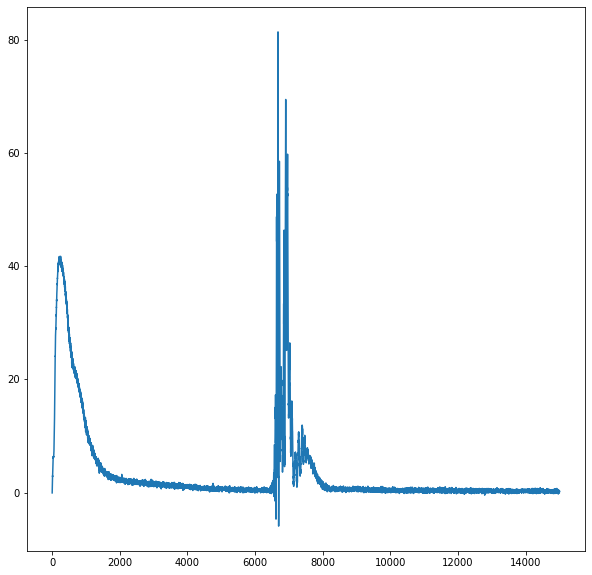

In [67]:
fig = plt.figure(figsize=(10, 10))
plt.plot(losses);

In [68]:
import numpy as np

X = np.linspace(-2, 2, 30)
Y = np.linspace(-2, 2, 30)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device)
grad_field = score_net(grid_tensor)
grad_field_np = grad_field.detach().cpu().numpy()
grad_field_np = grad_field_np[0]

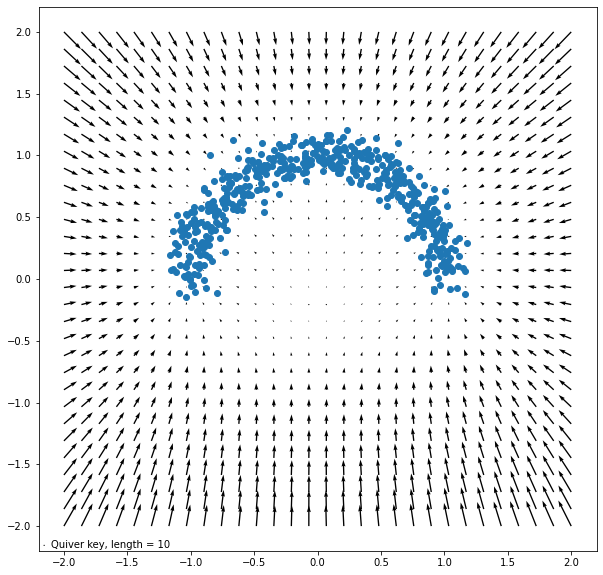

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
q = ax.quiver(grid[..., 0], grid[..., 1], grad_field_np[..., 0], grad_field_np[..., 1])
ax.quiverkey(q, X=0.01, Y=0.01, U=0.01, label='Quiver key, length = 10', labelpos='E')
sample_data = toy_data.inf_train_gen('one_moon', n_points=1000)
ax.scatter(sample_data[:, 0], sample_data[:, 1])
plt.show()

<Figure size 720x720 with 0 Axes>

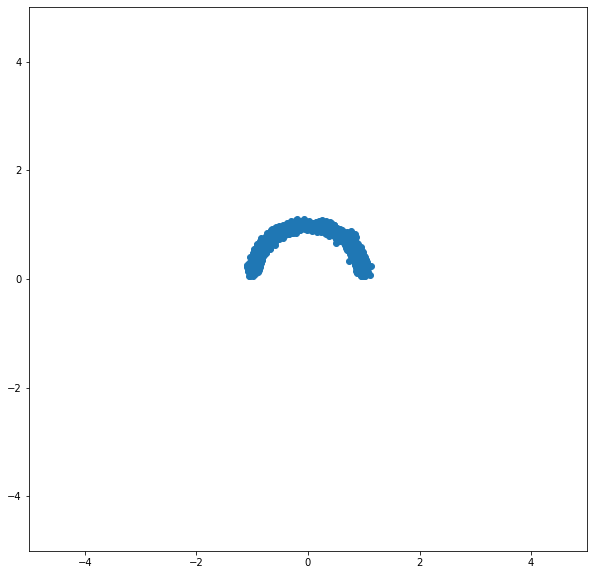

In [73]:
x_final = langevin_dynamics_lsd(score_net, l=0.01, e=.05, num_points=2048)
fig = plt.figure(figsize=(10, 10))
visualize_2d(x_final)